# Housing prices prediction
**Problem statement**

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.
 
The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
 
The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.
 
Also, determine the optimal value of lambda for ridge and lasso regression.

**Business goal**

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Solution structure
- Useful functions definition
- Data exploration
- Data cleaning and manipulation
    - Handling missing values
    - Columns with a single value
    - Columns description
    - Formatting columns
    - Remove duplicate records
    - Data enrichment
- Data analysis (EDA)
    - Categorical variables analysis
    - Numerical variables analysis
- Data preparation for modeling
    - Dummy variables
- Model building and evaluation
    - Linear Regression model analysis
    - Building a Regularized model with Ridge Regression
    - Building a Regularized model with Lasso Regression
- Summary
- Comparison of final models
- Conclusions

For this analysis, let's first import the Python libraries that will be used and define useful functions.

In [1]:
import pandas as pd              # Data manipulation tool
print('Pandas version: ',pd.__version__)
import seaborn as sns            # Data visualisation library
print('Seaborn version: ',sns.__version__)
import matplotlib
import matplotlib.pyplot as plt  # Data visualisation libray
print('Matplotlib version: ',matplotlib.__version__)
%matplotlib inline
import math                      # Mathematical functions
import numpy as np
print('numpy version: ',np.__version__)

# Model training library Sci-kit Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
print('SKLearn version: ',sklearn.__version__)

import warnings
warnings.filterwarnings('ignore') # Ignore warning messages

Pandas version:  1.3.4
Seaborn version:  0.11.2
Matplotlib version:  3.4.3
numpy version:  1.20.3
SKLearn version:  0.24.2


## Useful functions definition

Following function returns a dataframe with columns that contain null values and the percentage of them

In [2]:
def count_nullValues(df):
    # Get count of missing values, convert result to dataframe for aesthetic reasons
    df_null = df.isna().sum().to_frame() 

    # Rename aggregated column to "null_count"
    df_null.columns = ['null_count']

    # Add a column to show the percentage of null values for each column (data-driven metric)
    df_null['null_perc'] = df_null['null_count'].apply(lambda x: round(x/len(df) * 100,2))
    df_null = df_null[df_null['null_perc']>0].sort_values(by='null_perc', ascending=False)

    # Show for each column the count of null values and the percentage of them from "df" total rows
    return df_null.sort_values(by='null_perc', ascending=False)    

Following function drops the outliers of a given feature from a dataframe

In [3]:
def remove_outliers(df,col):
    q3 = np.percentile(df[col],75)
    q1 = np.percentile(df[col],25)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr    
    df_woOutliers = df[(df[col]>=lower_fence) & (df[col]<=upper_fence)]
    return df_woOutliers

Following function returns a dataframe with scoring metrics: R2, Adj. R2, RSS, MSE, RMSE

In [4]:
def get_scoreMetrics(y_train, y_train_pred , y_test, y_test_pred, features_count):
    # Get R-squared
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Get Adjusted R-squared
    n = len(y_train)
    p = features_count
    adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
    adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

    #Residual Sum of Squares
    rss_train = np.sum(np.square(y_train - y_train_pred))
    rss_test = np.sum(np.square(y_test - y_test_pred))

    # Mean Squared Error
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Root Mean Squared Error
    rmse_train = mse_train**0.5
    rmse_test = mse_test**0.5

    # Print metrics in a nice way
    metrics_mat = {'R-squared':[r2_train,r2_test],'Adj. R-squared':[adj_r2_train,adj_r2_test],'RSS':[rss_train,rss_test],'MSE':[mse_train,mse_test],'RMSE':[rmse_train,rmse_test]}
    metrics_df = pd.DataFrame(metrics_mat)
    
    return metrics_df

Following function returns a list of features selected by a model with its coefficients and exponential * 100 value (to 
interpret log transformation).

For Ridge and Lasso models only. Features are ordered by absolute value of coefficient

In [5]:
def get_selectedFeatures(model):
    # Get model parameters
    model_parameters = list(model.coef_)
    model_parameters.insert(0, model.intercept_)
    model_parameters = [round(x, 4) for x in model_parameters]

    # Exponential of model parameters
    exp_parameters = [(math.exp(x)-1)*100 for x in model_parameters]

    # Get columns names
    cols = X_train_trans.columns

    # For constant term
    cols = cols.insert(0, 'Constant')

    # Join column name and its coefficient
    columns_coeffs = list(zip(cols, model_parameters,exp_parameters))
    # Sort by absolute value of coefficient
    columns_coeffs.sort(key=lambda x: np.abs(x[2]),reverse=True)

    # Create a dataframe for better visualisation
    model_coeffs_df = pd.DataFrame(columns_coeffs, columns =['Feature', 'Coefficient', 'Exponential*100 value'])
    model_coeffs_df = model_coeffs_df[model_coeffs_df['Exponential*100 value']!=0.0]
    
    return model_coeffs_df

## Data exploration

Let's read the file "train.csv" which contains the data we need, and store it in a variable called "df" (for dataframe):

In [6]:
df = pd.read_csv('train.csv')

The function info() will let us see at first glance the composition of the data:

In [7]:
print('Data shape: ', df.shape,'\n')
df.info()

Data shape:  (1460, 81) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nu

In [8]:
# Count columns by datatype
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

We have **81 columns** and **1,460 records**. The columns distribution by data type is as follows:
- 43 columns of type object (categorical)
- 35 columns of type int64 (numerical)
- 3 columns of type float64 (numerical)

## Data cleaning and manipulation
Do we really need 81 columns for the analysis? Let's <b>review</b> what kind of data they hold and check <b>whether we can narrow down</b> the amount of columns we'll work with by:

1. Filtering columns by missing values
2. Filtering single-value columns
3. Understanding each column (variable) description to check if it fits in analisys

### Handling missing values
Let's obtain the columns with missing values and the count of missing values. Then we can decide if drop columns by this criteria or impute the missing values.

In [9]:
# Get count of missing values, convert result to dataframe for aesthetic reasons
df_null = count_nullValues(df)
print('Total columns with missing values: ', len(df_null))
df_null

Total columns with missing values:  19


null_count  null_perc
PoolQC              1453      99.52
MiscFeature         1406      96.30
Alley               1369      93.77
Fence               1179      80.75
FireplaceQu          690      47.26
LotFrontage          259      17.74
GarageFinish          81       5.55
GarageCond            81       5.55
GarageQual            81       5.55
GarageYrBlt           81       5.55
GarageType            81       5.55
BsmtExposure          38       2.60
BsmtFinType2          38       2.60
BsmtFinType1          37       2.53
BsmtCond              37       2.53
BsmtQual              37       2.53
MasVnrArea             8       0.55
MasVnrType             8       0.55
Electrical             1       0.07

We can see **19 columns have null/empty values** in different percentages.

According to data dictionary, the **categorical columns values include "NA"**, which refers to an **absence of the feature/facility**. This can affect the price, so we cannot remove columns with high number of missing values.

**We'll replace null values with "NA" for categorical variables**, except for "Electrical" column that must not have that value.

In [10]:
# Get list of categorical columns to update
df_null_cat = ((df[df_null.index].select_dtypes(include=['object'])).drop('Electrical',axis=1)).columns

# For each column replace null value with string "NA"
for col in df_null_cat:
    df[col].fillna("NA", inplace=True)

Check the columns that still contain null values:

In [11]:
# Get count of missing values, convert result to dataframe for aesthetic reasons
df_null_after_cat = count_nullValues(df)
print('Total columns with missing values: ', len(df_null_after_cat))
df_null_after_cat

Total columns with missing values:  4


null_count  null_perc
LotFrontage         259      17.74
GarageYrBlt          81       5.55
MasVnrArea            8       0.55
Electrical            1       0.07

Let's take a **closer look** to the **columns with null values** by printing their distribution description with visual help - distplot, and their values counts to understand the data.

**LotFrontage column**

 Linear feet of street connected to property

In [12]:
# Describe LotFrontage column
df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

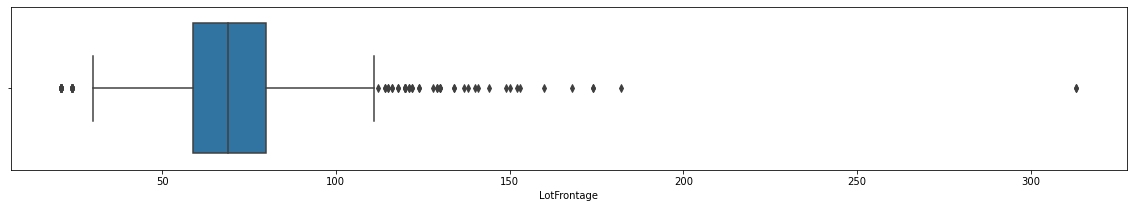

In [13]:
# Create a boxplot for LotFrontage
plt.figure(figsize=[20,3])
sns.boxplot(df['LotFrontage'])
plt.show()

In [14]:
# Print LotFrontage unique values
df['LotFrontage'].unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

For **LotFrontage** column we have outliers so we'll replace null values with median.

But as this feature depends on the neighborhood, we'll use the median by neighborhood so by it they have similar features (and thus similar price according to these). Also, we'll round down the number to preserve integer values in the column.

In [15]:
# Replace LotFrontage null values with median by neighborhood
df['LotFrontage'] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(math.floor(x.median())))

**GarageYrBlt column**

Year garage was built

In [16]:
# Describe GarageYrBlt column
df['GarageYrBlt'].describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

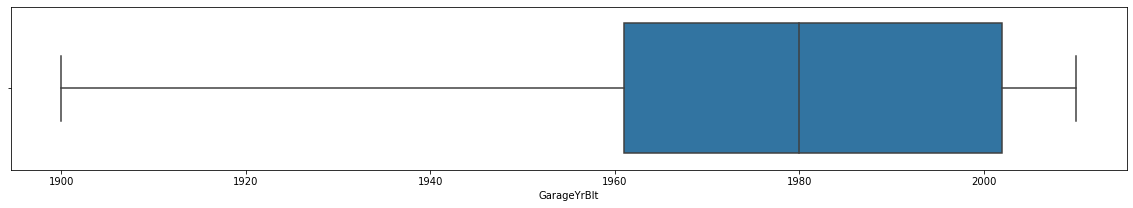

In [17]:
# Create a boxplot for GarageYrBlt
plt.figure(figsize=[20,3])
sns.boxplot(df['GarageYrBlt'])
plt.show()

In [18]:
# Print GarageYrBlt unique values
df['GarageYrBlt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

For **GarageYrBlt** column we do not have outliers and we have integer values (will deal with data types later). We still need to represent years so we'll use the median to fill null values. 

In this case the year the garage was built does not depend on neighborhood so we can use general median value.

In [19]:
# Replace GarageYrBlt null values with median
df['GarageYrBlt'].fillna(math.floor(df['GarageYrBlt'].median()), inplace=True)

**MasVnrArea column**

Masonry veneer area in square feet

In [20]:
# Describe MasVnrArea column
df['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

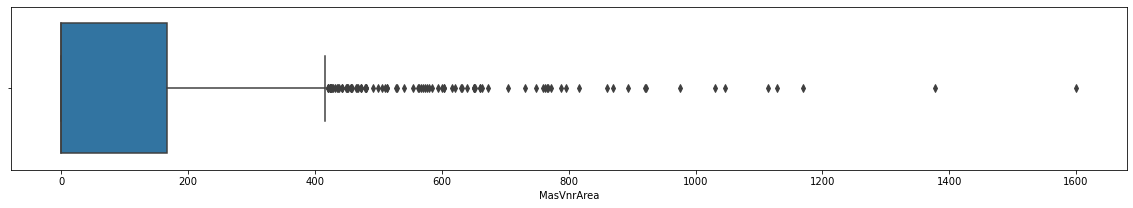

In [21]:
# Create a boxplot for MasVnrArea
plt.figure(figsize=[20,3])
sns.boxplot(df['MasVnrArea'])
plt.show()

In [22]:
# Print MasVnrArea unique values (first 20)
df['MasVnrArea'].unique()[:20]

array([196.,   0., 162., 350., 186., 240., 286., 306., 212., 180., 380.,
       281., 640., 200., 246., 132., 650., 101., 412., 272.])

For **MasVnrArea** column we have outliers and integer values (will deal with data types later) so we'll replace null values with median.

In this case the feature does not depend on neighborhood so we can use general median value. Also, we'll round down the number to preserve integer values in the column.

In [23]:
# Replace MasVnrArea null values with median
df['MasVnrArea'].fillna(math.floor(df['MasVnrArea'].median()), inplace=True)

**Electrical column**
Type of electrical system

In [24]:
# Describe Electrical column
df['Electrical'].describe()

count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

For this categorical column we only have one missing value, we'll fill it with the general mode of Electrical as it does not depend on the area the house is in.

In [25]:
# Replace Electrical null values with mode
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

Let's finally **check we do not have any more null values**.

In [26]:
# Get count of missing values, convert result to dataframe for aesthetic reasons
df_null_after_num = count_nullValues(df)
print('Total columns with missing values: ', len(df_null_after_num))
df_null_after_num

Total columns with missing values:  0


Empty DataFrame
Columns: [null_count, null_perc]
Index: []

### Columns with a single value
These kind of columns do not add information for the results as the variance is zero, situation that can cause errors or unexpected results. We'll remove this columns.

In [27]:
# Use the nunique pandas function to count number of distinct elements in specified axis
# Filter "df" dataset to keep columns with result different of one (not single values)
print('Total columns: ', len(df.columns))
df = df.loc[:,df.apply(pd.Series.nunique) != 1]
print('Total columns after dropping ones with single value: ', len(df.columns))

Total columns:  81
Total columns after dropping ones with single value:  81


**We do not have columns with a single value.**

### Column description
By data dictionary every variable describes a different feature/facility of a house, except for the Id column that is unique to a record and does not add information about data. **We'll remove Id column**.

In [28]:
# Drop Id column
df.drop(['Id'],axis=1,inplace=True)

If we need to drop columns, will be by their correlation (multicollinearity), which comes in a later section.

### Formatting columns
We will format variables according to their content (i.e. numbers to numeric type) and decide if we need to transform any of them.

**All columns formatting**

We'll replace "None" value with "NA" to be consistent with data dictionary.

In [29]:
df.replace('None','NA',inplace=True)

**MSZoning column**

According to data dictionary this column identifies the general zoning classification of the sale.

In [30]:
# Get MSZoning column unique values
df['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

We can see that the category "C (all)" does not correspond with data dictionary that describes a value of "C". We'll format it to be "C" instead of current value.

In [31]:
# Drop addr_state and zip_code columns.
df['MSZoning'] = df['MSZoning'].apply(lambda x: 'C' if x == 'C (all)' else x)
df['MSZoning'].unique()

array(['RL', 'RM', 'C', 'FV', 'RH'], dtype=object)

**Float64 data type columns**

The columns with float64 data type actually have only integer values, so we'll convert them to integer.

In [32]:
# Change data type for float64 columns
df[df.select_dtypes(include=['float64']).columns] = df[df.select_dtypes(include=['float64']).columns].astype(int)

**Int64 data type columns**

To optimize columns transformations we'll transform all integer columns to int32 data type.

In [33]:
# Change data type for float64 columns
df[df.select_dtypes(include=['int64']).columns] = df[df.select_dtypes(include=['int64']).columns].astype(int)

In [34]:
# Count columns by datatype
df.dtypes.value_counts()

object    43
int32     37
dtype: int64

### Remove duplicate records
We will remove duplicate records with drop_duplicates function.

In [35]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Print dataframe shape
df.shape

(1460, 80)

**We do not have duplicate records.**

After analysing the columns definition and formatting them, **we kept 80 columns and all rows**.

Identified categorical variables as per their data type <i>object</i>, we have 43. From variables with integer data type we have 8 columns that can also be treated like categorical ones.

These are the also categorical columns with integer data type, which have date time or categorical values:
- MSSubClass
- OverallQual
- OverallCond
- YearBuilt
- YearRemodAdd
- GarageYrBlt
- MoSold
- YrSold

We have **43 categorical columns** and **37 numerical columns**.

### Data enrichment

We'll create a business driven metric from variables <i>YearBuilt</i> and <i>YrSold</i> to determine the age in years of the house when it was sold, and will be called <i>HouseAge</i>.

In Data Analysis section we'll see if this variable relates better to target variable than the other two.

In [36]:
# Create HouseAge column
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

# Print top values of new column
df['HouseAge'].head()

0     5
1    31
2     7
3    91
4     8
Name: HouseAge, dtype: int32

**After enrichment we have 81 columns**:
- 43 categorical columns
- 38 numerical columns

We'll save the column names by type of variable to facilitate further analysis.

In [37]:
# Categorical columns with date data type
cat_date = ['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

In [38]:
# Save list of categorical columns
cat_cols = list(df.select_dtypes(include=['object']).columns)
print('Categorical columns: ',len(cat_cols))

# Save a dataframe with categorical variables only and target variable
df_cat = df[cat_cols+['SalePrice']]

Categorical columns:  43


In [39]:
# Select integer type columns
int_type_df = df.select_dtypes(include=['int32'])

# Filter out the categorical columns with integer data type
num_cols = list(int_type_df.columns)
print('Numerical columns: ',len(num_cols))

# Dataframe with numerical variables only
df_num = df[num_cols]

Numerical columns:  38


## Data analysis

### Categorical variables analysis

#### Univariate analysis
We'll plot the total records by category for each independent variable and get insights about the data distribution.

First we'll take a look into **all non-date columns records by category** to obtain some insights.

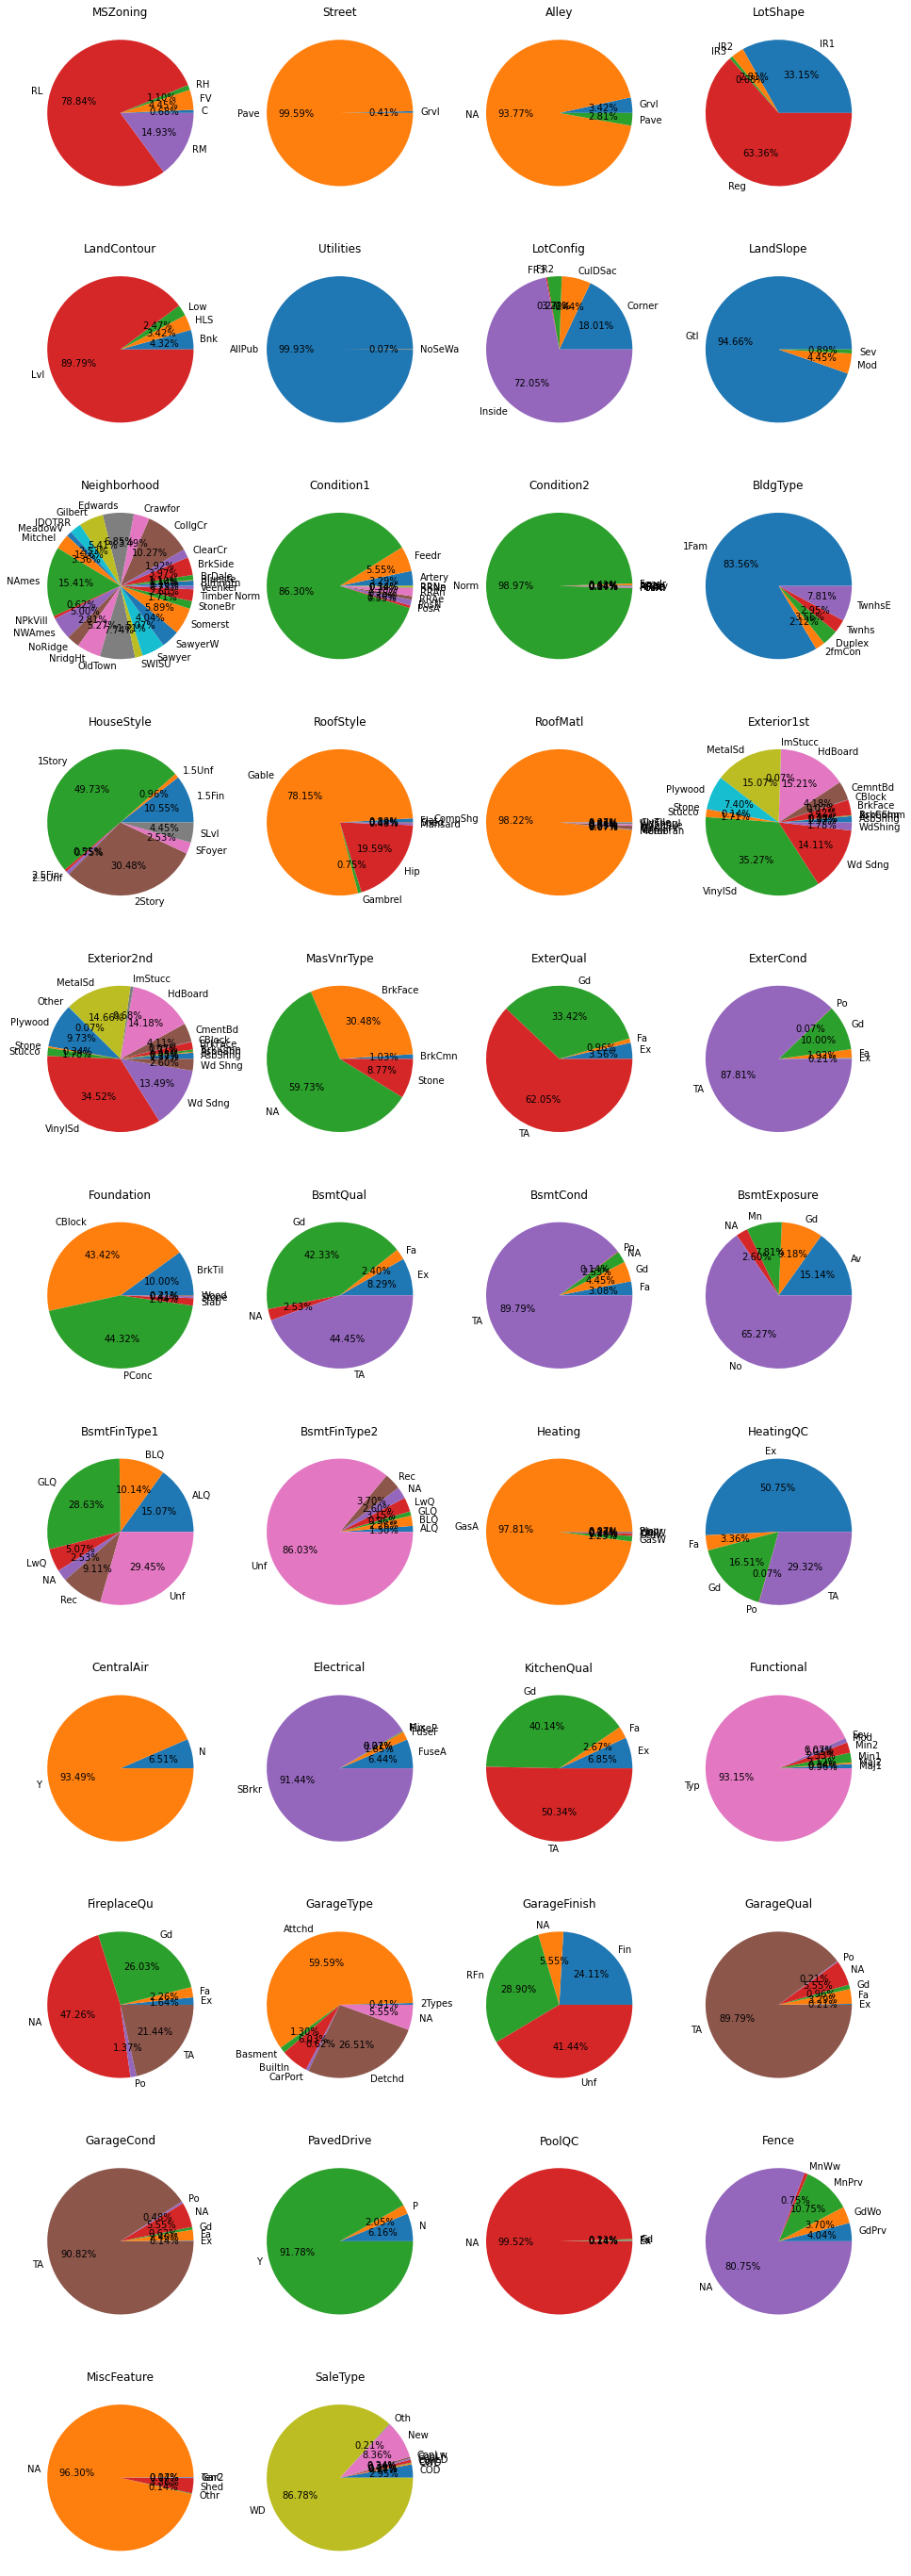

In [40]:
# Define graphs matrix properties
gr_cols = 4
gr_rows = math.ceil((len(df_cat.columns)-1)/gr_cols)

# To show multiple graphs
fig, ax = plt.subplots(gr_rows, gr_cols, figsize=(16, 50))

# Create histograms
r = 0
c = 0
for col in df_cat.columns:
    if col != 'SalePrice':
        agg_tbl = pd.pivot_table(df_cat, index=col, values='SalePrice', aggfunc='count')
        ax[r,c].pie(agg_tbl['SalePrice'], labels = agg_tbl.index, autopct='%.2f%%')
        ax[r,c].title.set_text(col)
        if r < gr_rows and c < gr_cols-1:
            c += 1
        elif r < gr_rows:
            r += 1
            c = 0
# Handle empty graph to show
fig.delaxes(ax[gr_rows-1,2])
fig.delaxes(ax[gr_rows-1,3])
plt.show()

From above pie charts we can see the total records by categories from categorical variables excluding date columns. The **insights** we obtain **indicate the distribution of categories in the dataset**.

Many variables have **have a percentage of total records in one of the categories greater than 85%**. The best scenario is that most part of the houses in the dataset have these standards and represents actual population. But if we want to predict for unseen data that does not correspond to the category with highest percentage of records in training, the error can be higher if variable is included in final model (**the variables can lead to high bias**). **We'll remove these variables**.

The **rest of the categories have more or less fair distribution of total records by category**, which could lead to them being included in final model as would not represent high bias (by considering each one of them alone with target variable).

Now we'll **plot the date columns** to see their total records by categories.

In [41]:
# Dataframe with date columns only
df_cat_Dates = df[cat_date+['SalePrice']]

We'll **create bins to visualize in an easier way** the columns with a year value 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', and 'MoSoldQuarter'.

In [42]:
# Binning some year columns into 50 years bins
df_cat_Dates['YearBuiltBin'] = pd.cut(x=df_cat_Dates['YearBuilt'], bins=[1849, 1899, 1949, 1999, 2049])
df_cat_Dates['YearRemodAddBin'] = pd.cut(x=df_cat_Dates['YearRemodAdd'], bins=[1899, 1949, 1999, 2049])
df_cat_Dates['GarageYrBltBin'] = pd.cut(x=df_cat_Dates['GarageYrBlt'], bins=[1899, 1949, 1999, 2049])

# Binning MoSold into year quarters
df_cat_Dates['MoSoldQuarter'] = pd.cut(x=df_cat_Dates['MoSold'], bins=[1, 3, 6, 9, 12])

df_cat_Dates_Bin = df_cat_Dates.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold'],axis=1)
df_cat_Dates_Bin.head()

YrSold  SalePrice  YearBuiltBin YearRemodAddBin GarageYrBltBin  \
0    2008     208500  (1999, 2049]    (1999, 2049]   (1999, 2049]   
1    2007     181500  (1949, 1999]    (1949, 1999]   (1949, 1999]   
2    2008     223500  (1999, 2049]    (1999, 2049]   (1999, 2049]   
3    2006     140000  (1899, 1949]    (1949, 1999]   (1949, 1999]   
4    2008     250000  (1999, 2049]    (1999, 2049]   (1999, 2049]   

  MoSoldQuarter  
0        (1, 3]  
1        (3, 6]  
2        (6, 9]  
3        (1, 3]  
4       (9, 12]

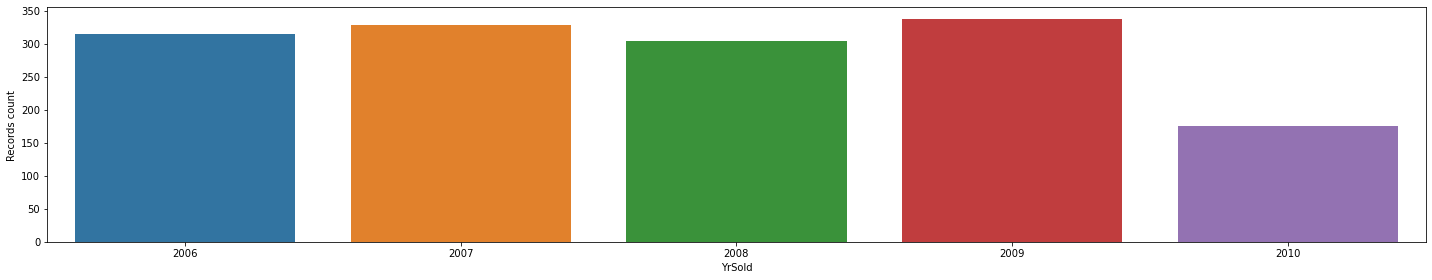

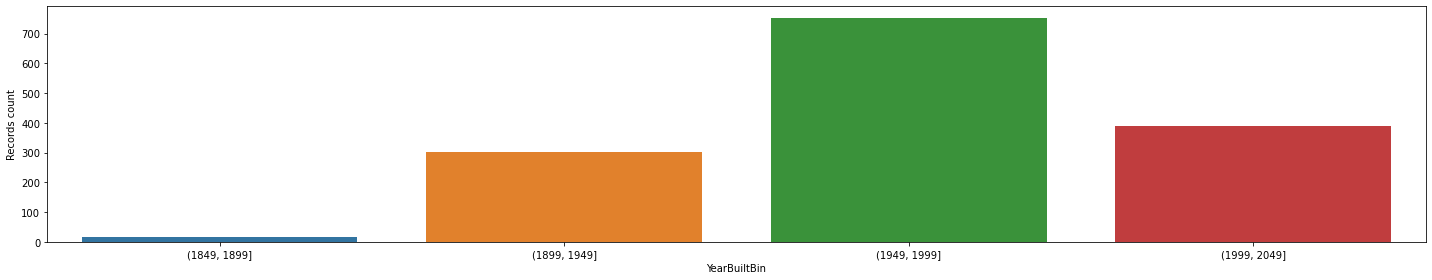

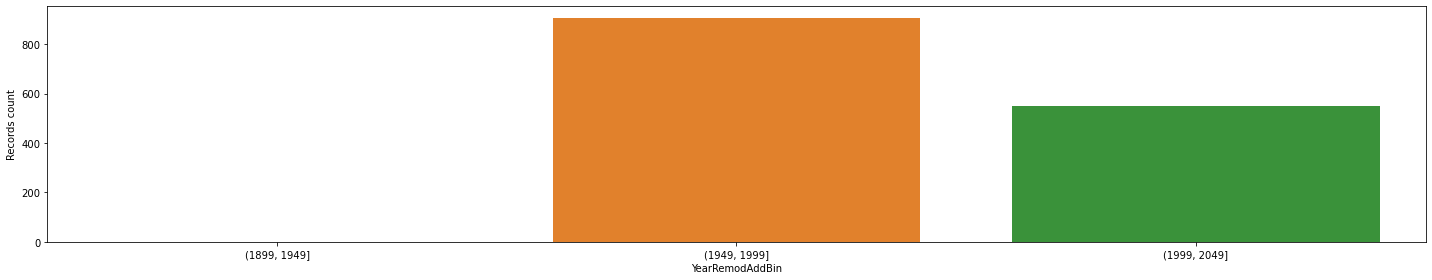

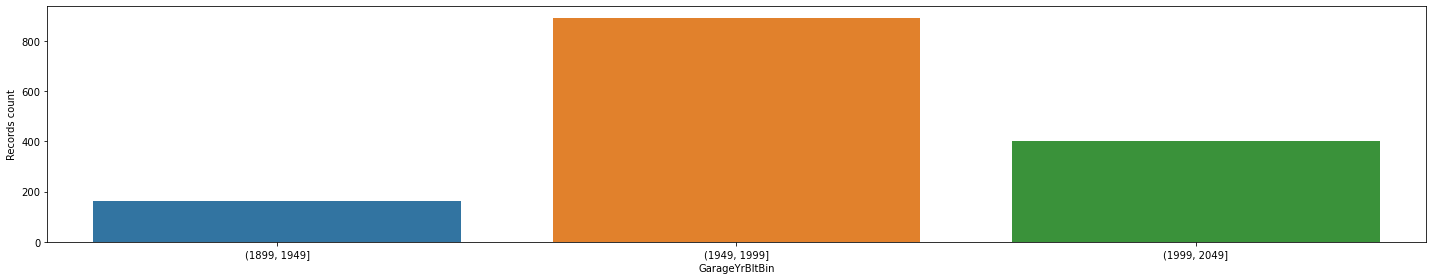

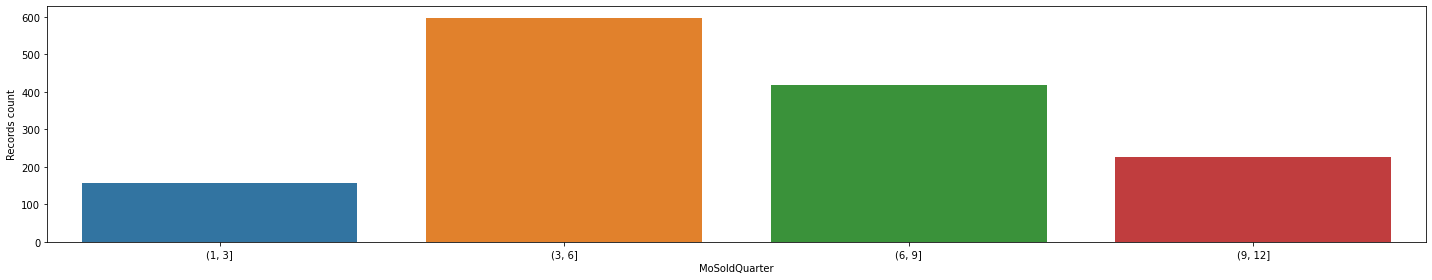

In [43]:
# Count records by category for date columns
for col in df_cat_Dates_Bin.columns:
    if col != 'SalePrice':
        pivotted = pd.pivot_table(df_cat_Dates, index=col, values='SalePrice', aggfunc='count')
        plt.figure(figsize=[20,4])
        ax = sns.barplot(data=pivotted, x=pivotted.index, y='SalePrice')
        plt.tight_layout()
        ax.set(ylabel='Records count')
        plt.show()

From above bar charts we can see the total records by categories from categorical variables with date data type (year/month). The insights we obtain are:
- **All houses** in data set were **sold** in a year **between (inclusive) 2006 and 2010**. For future review, datase should be updated with newer sells to improve modeling.
- **Most houses were sold in the middle of the year (Q2 and Q3)**. One reason for this could be the lack of competition in selling during major festivities, which are mostly at the end and beginning of the year.
- **Most houses were built between 1950 and 1999**, and also in those dates they were the **most remodeled**.
    - The **garage built** was the most done in these range of years too, so it might be linked to houses being remodeled too (these two variables might have high correlation).

#### Bivariate analysis
We'll plot the category distribution for each independent variable against the target variable SalePrice to get insights.

In [44]:
# Create a list of variables with a large amount of categories (to plot them aside)
large_cats = ['Neighborhood','Exterior1st','Exterior2nd']

In [45]:
# Show variables with small count of categories
df_cat_small = df_cat.loc[:, ~df_cat.columns.isin(large_cats)]

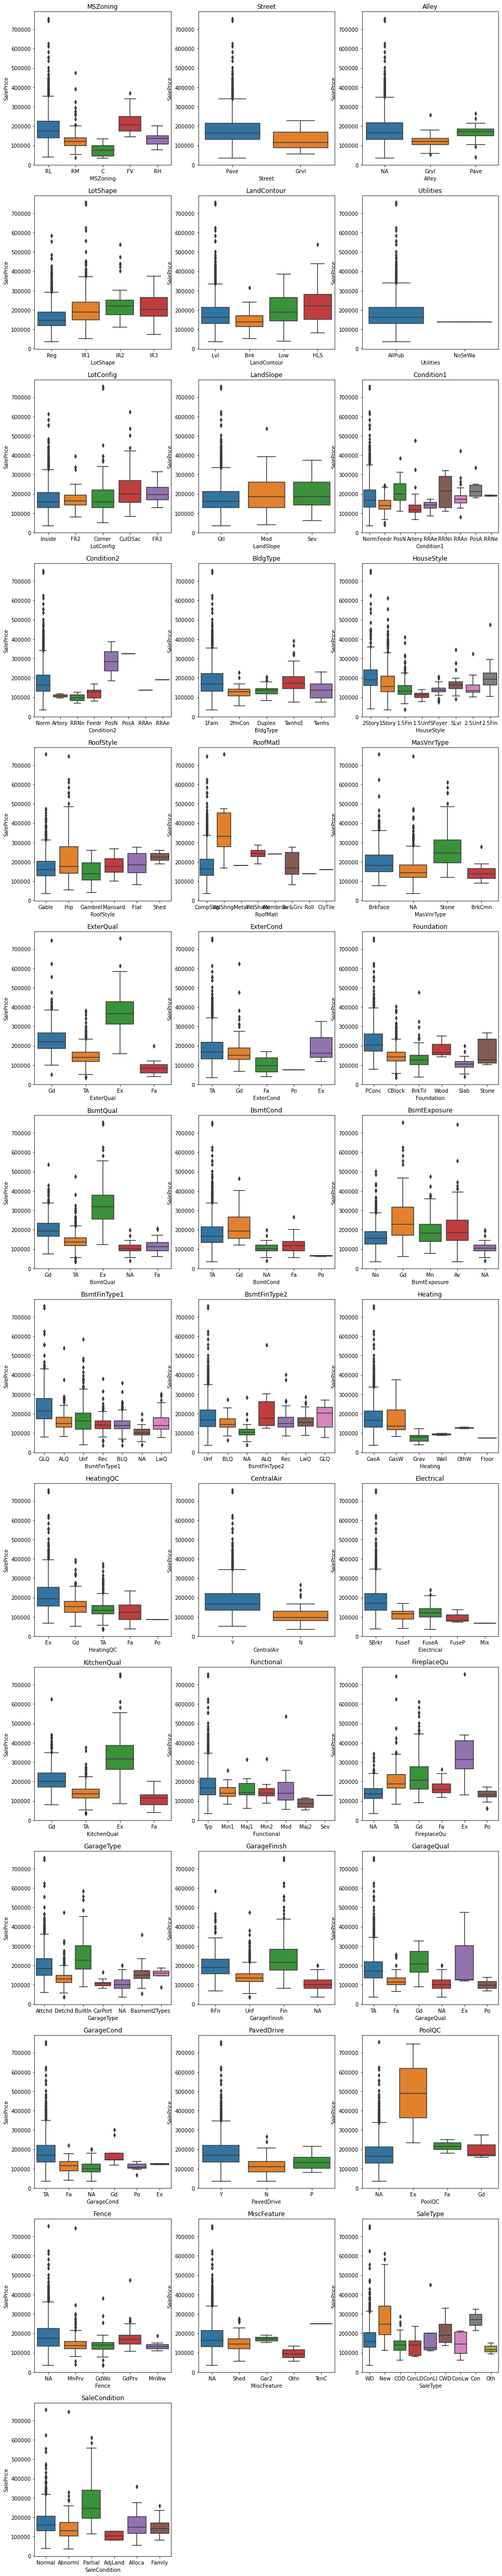

In [46]:
# Define graphs matrix properties
gr_cols = 3
gr_rows = math.ceil((len(df_cat_small.columns)-1)/gr_cols)

# To show multiple graphs
fig, ax = plt.subplots(gr_rows, gr_cols, figsize=(16, 90))

# Create histograms
r = 0
c = 0
for col in df_cat_small.columns:
    if col != 'SalePrice':
        sns.boxplot(ax=ax[r,c], x = col, y = 'SalePrice', data = df_cat_small)
        ax[r,c].title.set_text(col)
        if r < gr_rows and c < gr_cols-1:
            c += 1
        elif r < gr_rows:
            r += 1
            c = 0
# Handle empty graph to show
fig.delaxes(ax[13,1])
fig.delaxes(ax[13,2])
plt.show()

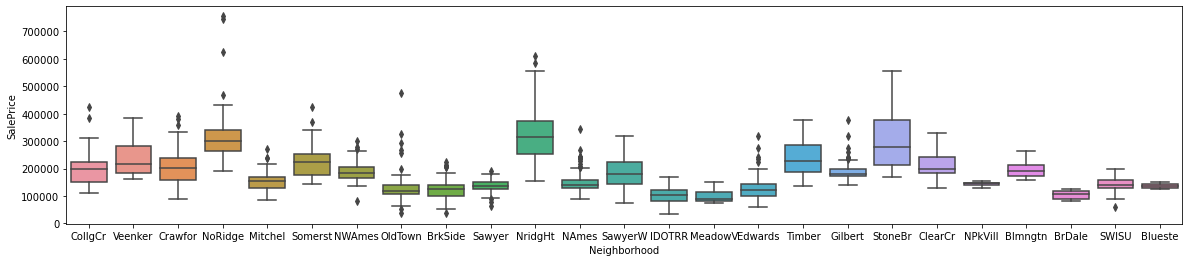

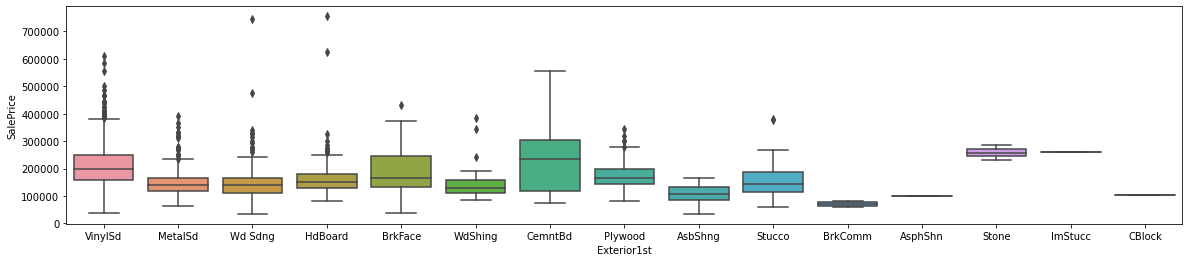

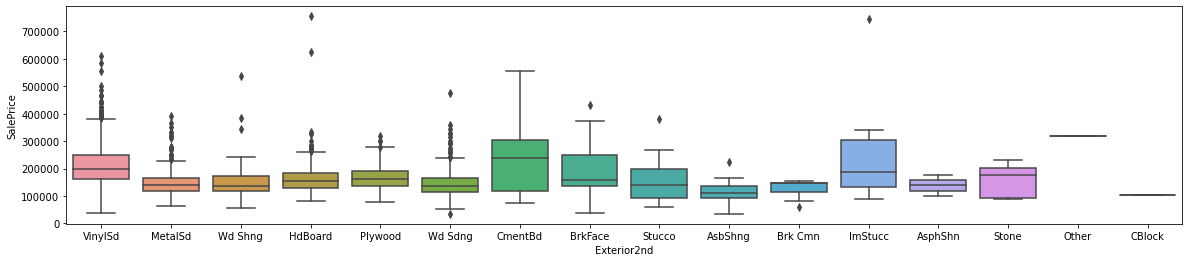

In [47]:
# Show variables with large count of categories
df_cat_large = df.loc[:, df.columns.isin(large_cats+['SalePrice'])]

for col in df_cat_large:
    if col != 'SalePrice':
        plt.figure(figsize=[20,4])
        sns.boxplot(x = col, y = 'SalePrice', data = df_cat_large)
        plt.show()

From above box plots we can see that the **most marked trends** are with the **variables *OverallQual* and *OverallCond***, variables that rate the overall material and finish of the house and the overall condition of the house: **the higher the value the higher the house Sale Price**. This relationship is expected as houses with better rates are high demand ones.

For the rest of the variables we have a variety of distributions by category, so we only **list** here **some of the ones** with high differences in distribution by category as they **might have a bigger effect on the *SalePrice***:
- MSZoning
- Street
- Utilities
- Condition2
- ExternQual
- ExterCond
- BsmntQual
- Heating
- Electrical
- KitchenQual
- PoolQc
- GarageType
- Neighborhood
- Exterior1st

#### Removing high skewed variables
**We'll remove categorical variables** with a percentage of total records in **one of the categories greater than 85%**, as they will turn into skewness in final model.

In [48]:
# List of categorical variables to remove
cats_to_remove = ['Street','Alley','LandContour','Utilities','LandSlope','Condition1','Condition2','RoofMatl','ExterCond','BsmtCond','BsmtFinType2','Heating','CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive','PoolQC','MiscFeature','SaleType']

In [49]:
# Drop columns from df
df.drop(cats_to_remove,axis=1,inplace=True)

In [50]:
# Count columns by datatype
df.dtypes.value_counts()

int32     38
object    22
dtype: int64

**We have now 60 columns**:
- 22 categorical
- 38 numerical

### Numerical variables analysis

#### Handling outliers

Let's review the box plots for numerical variables to understand their outliers distribution.

In [51]:
# Dataframe with numerical variables only (except target variable SalePrice)
df_num = df[num_cols]
df_num_woSa = df_num.loc[:, ~df_num.columns.isin(['SalePrice'])]

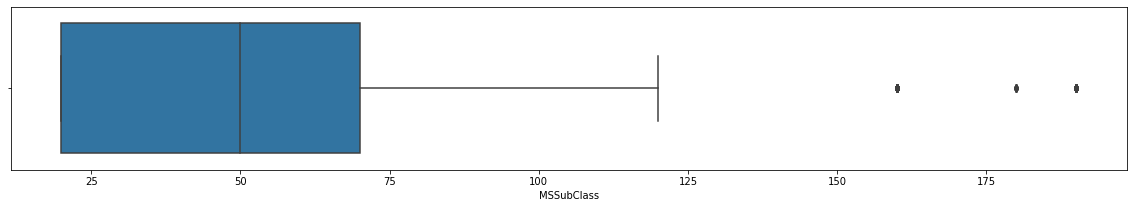

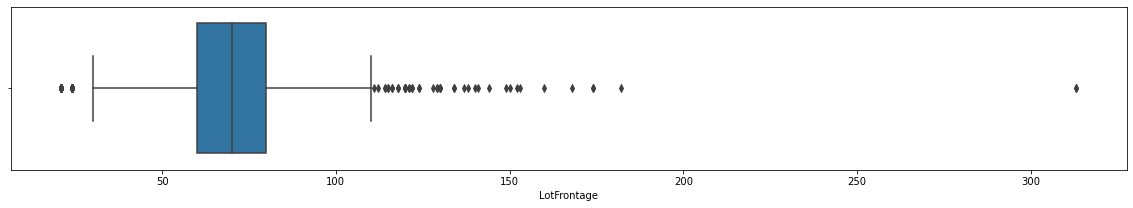

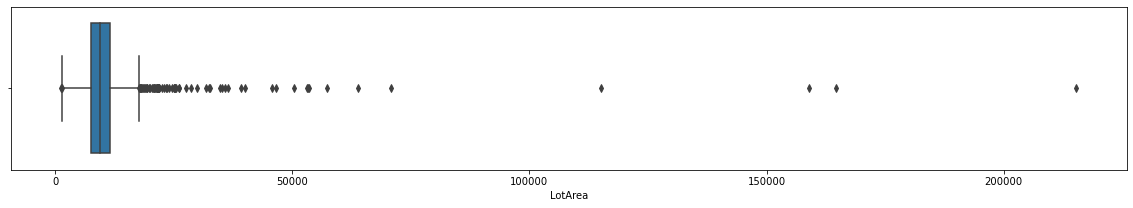

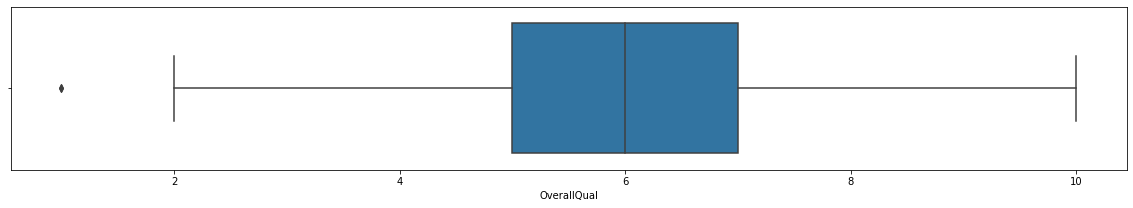

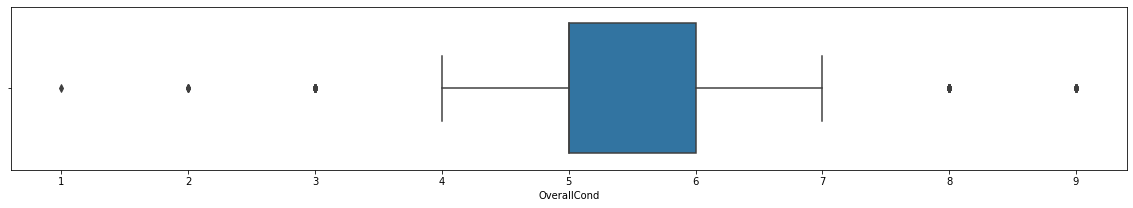

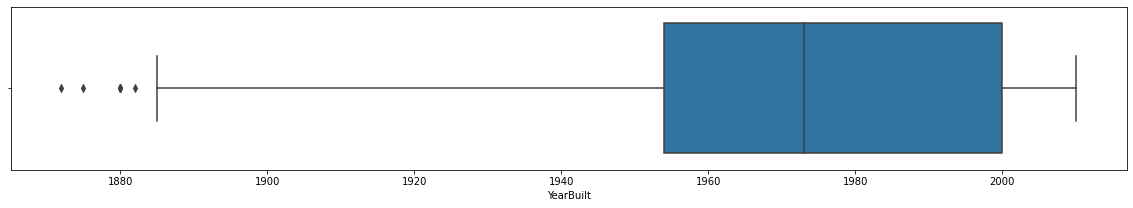

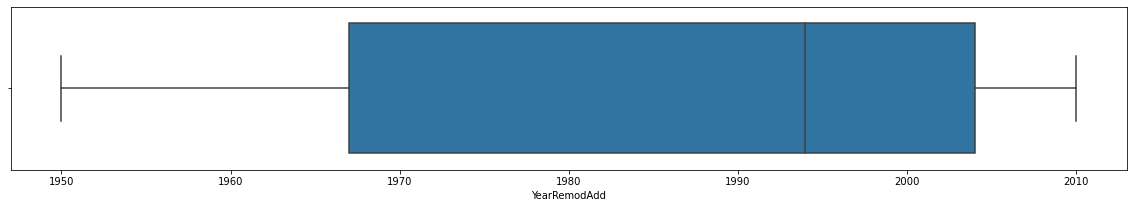

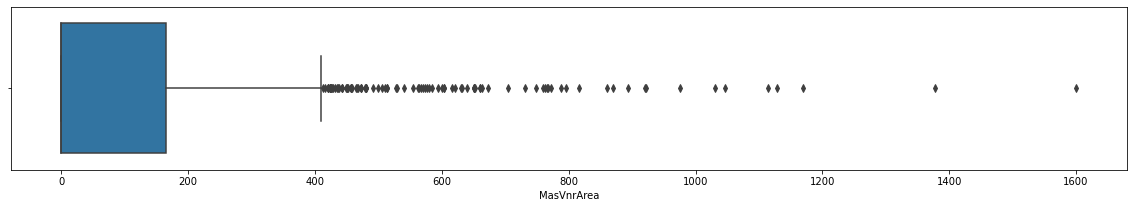

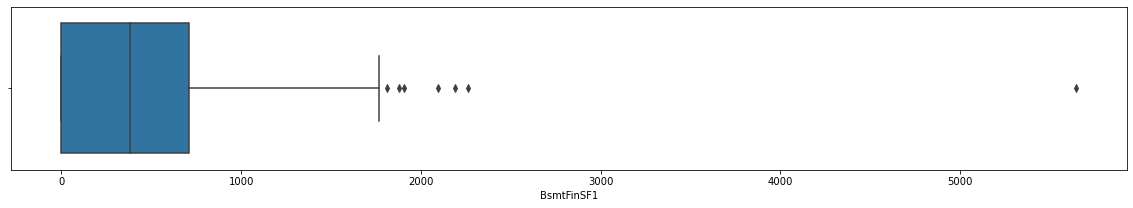

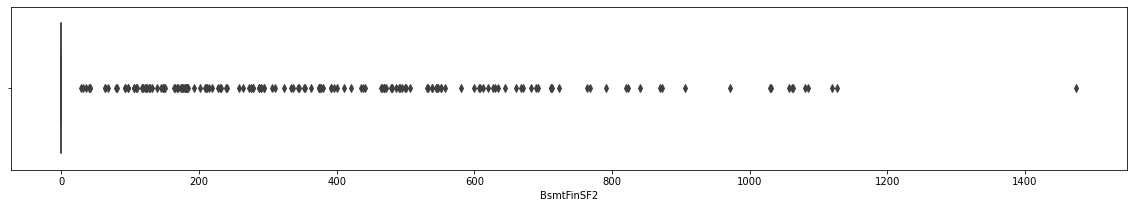

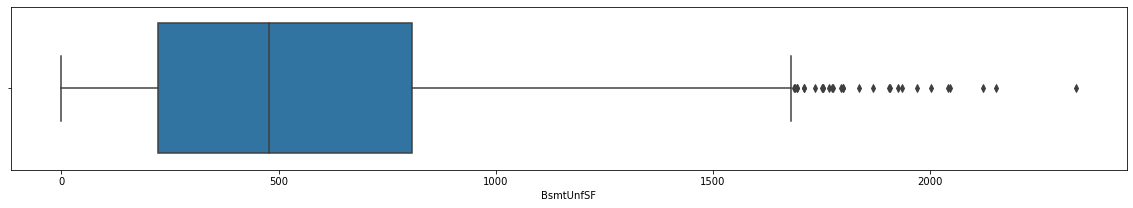

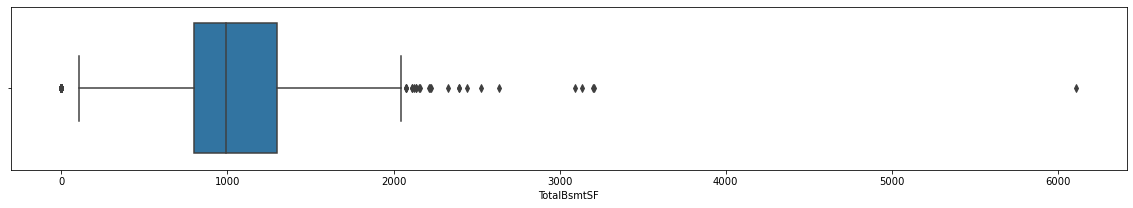

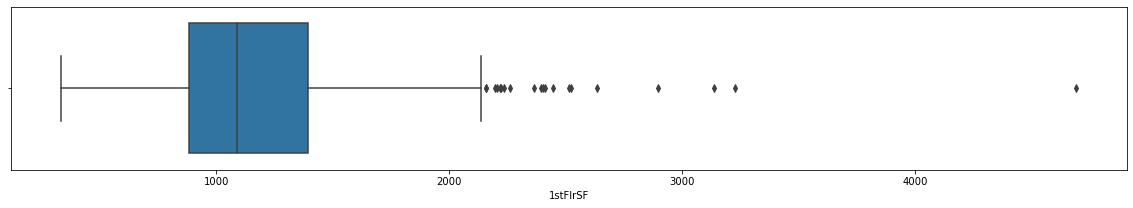

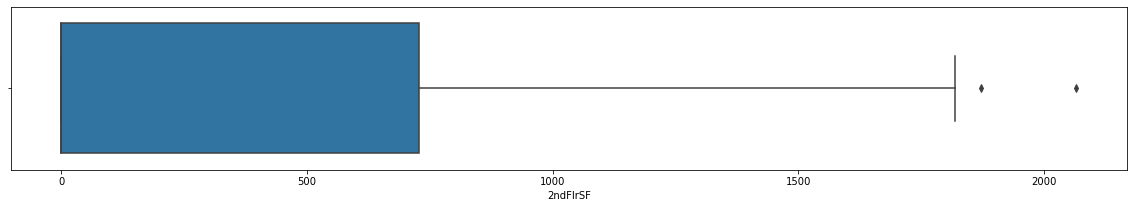

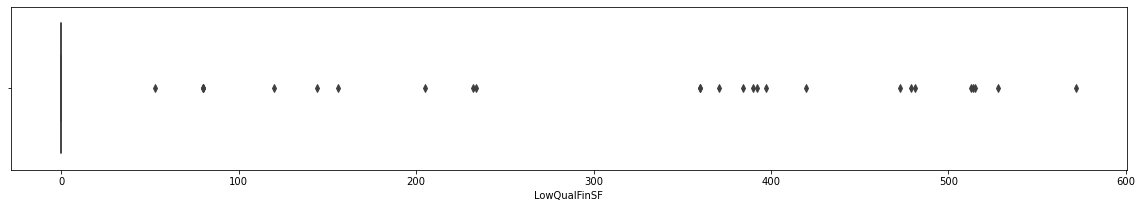

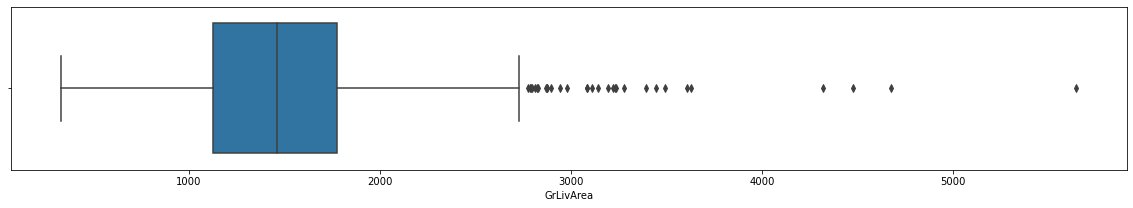

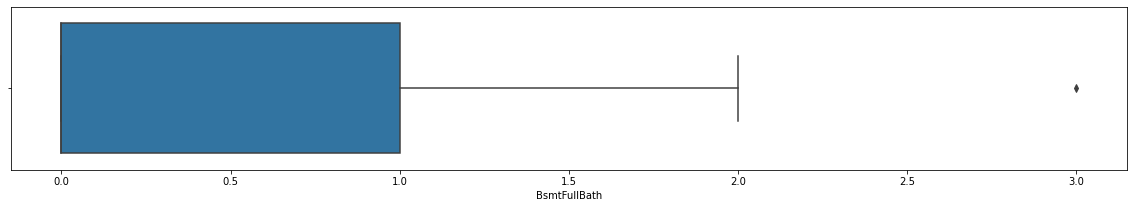

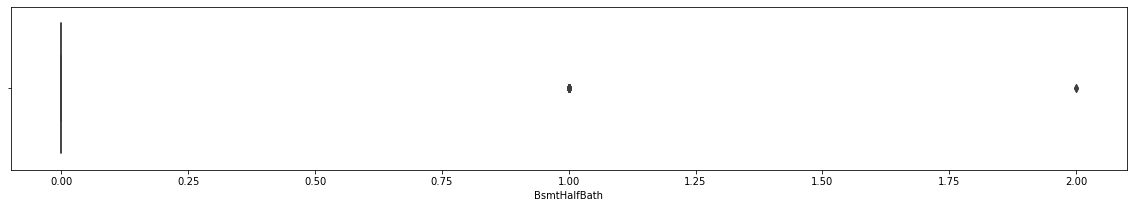

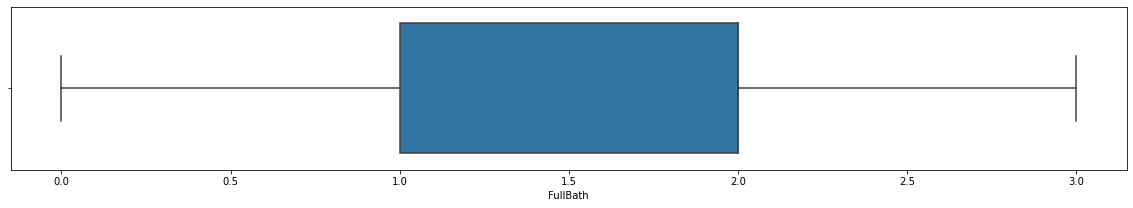

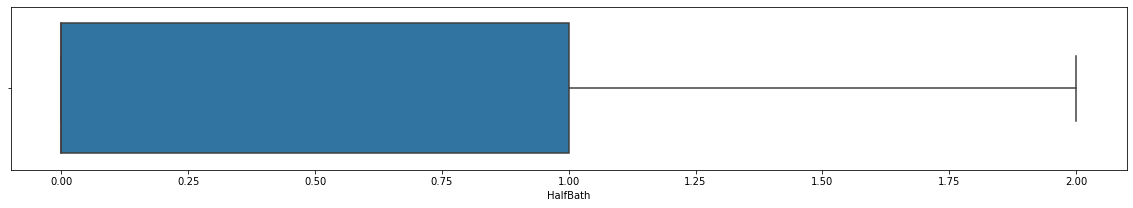

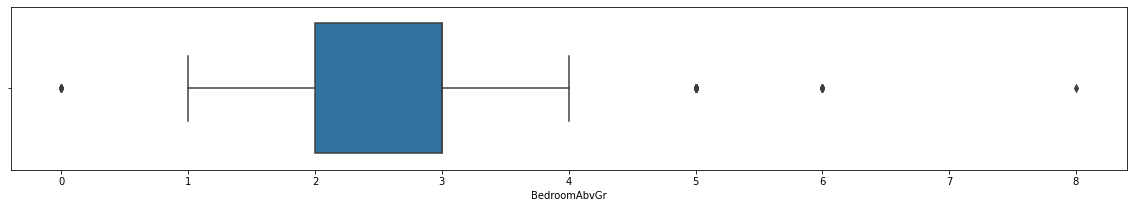

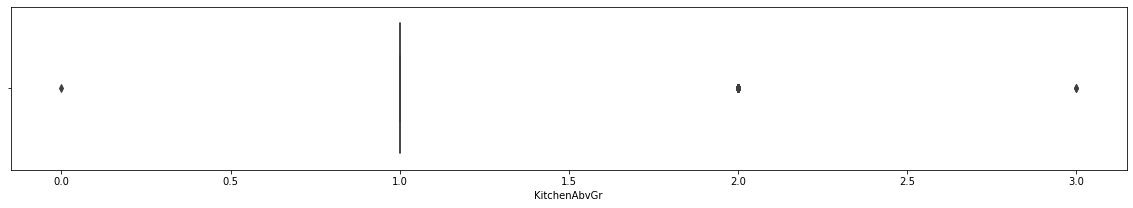

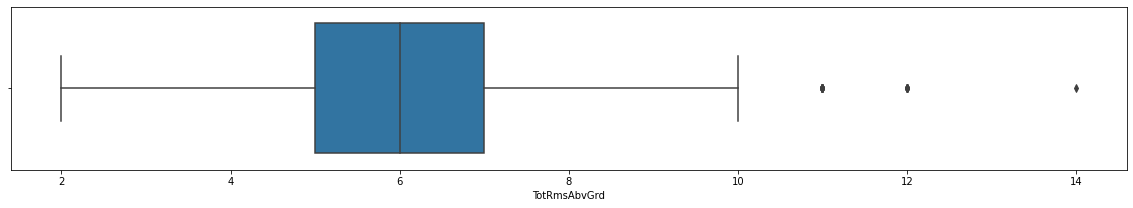

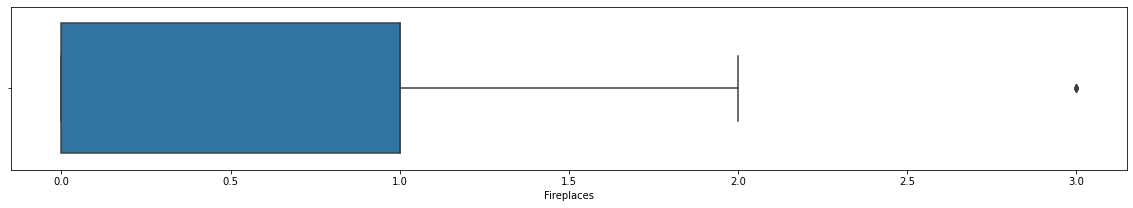

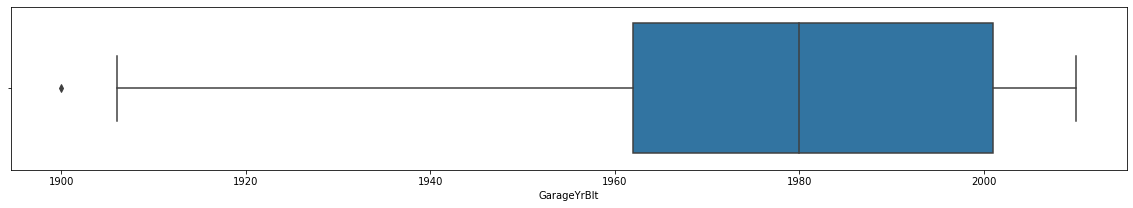

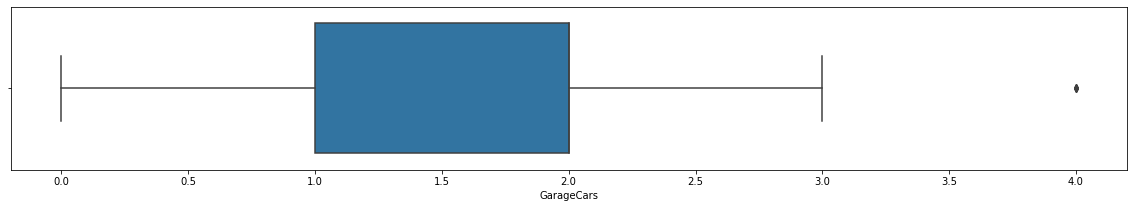

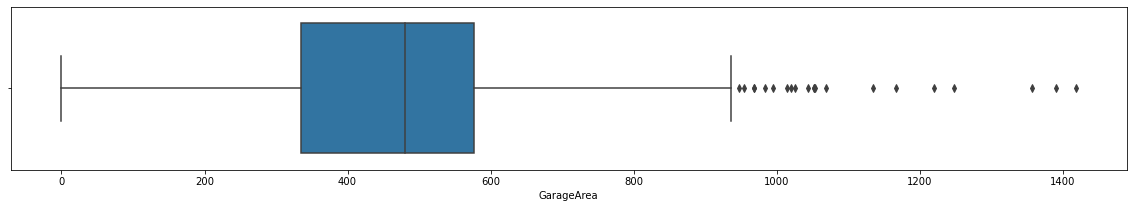

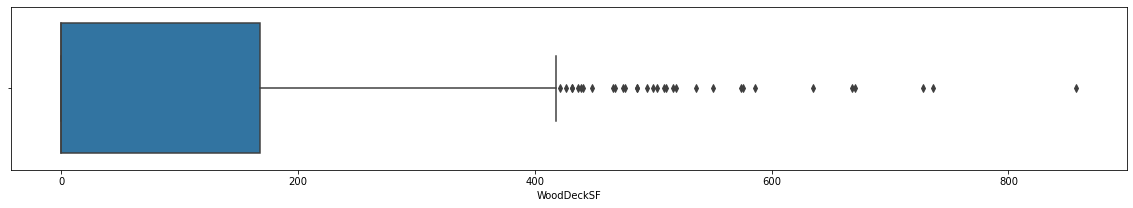

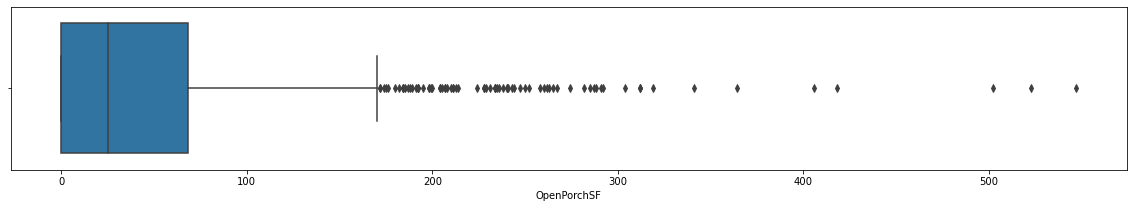

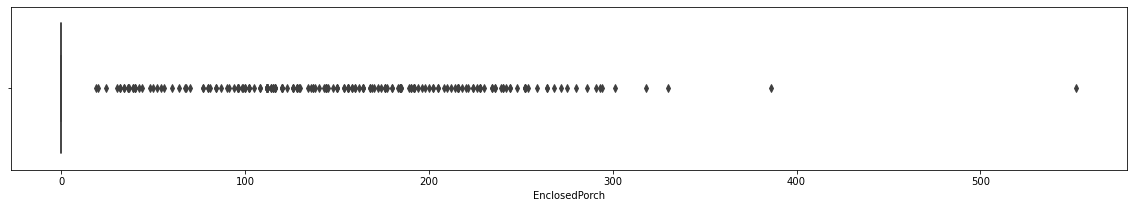

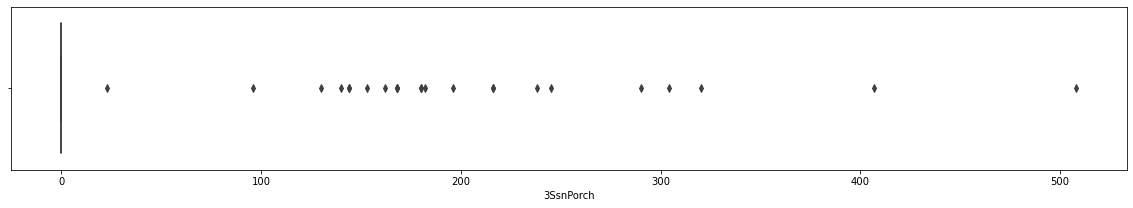

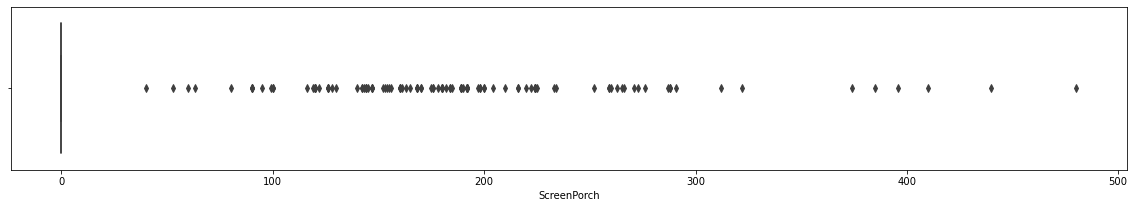

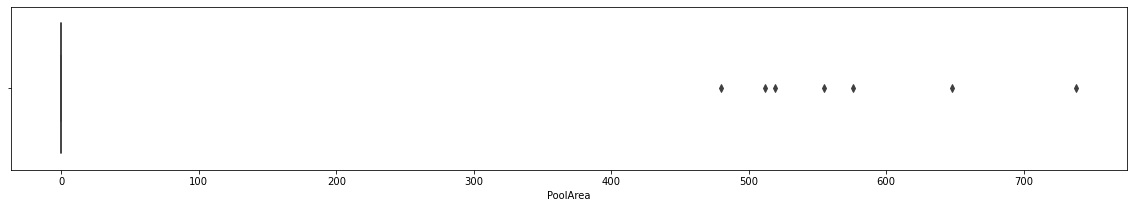

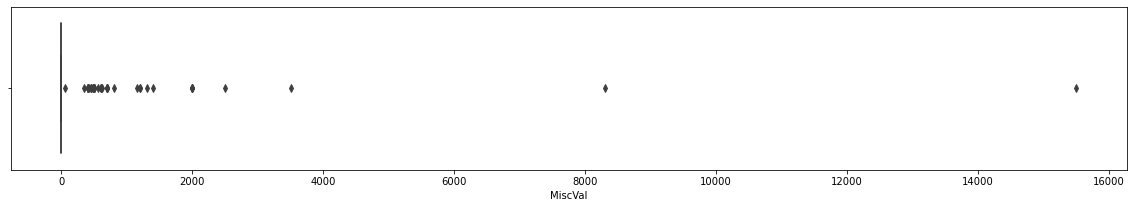

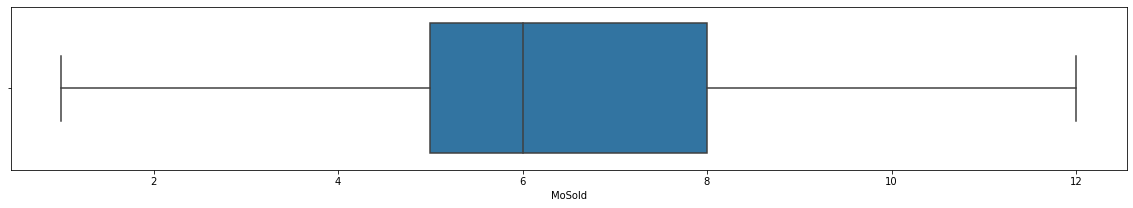

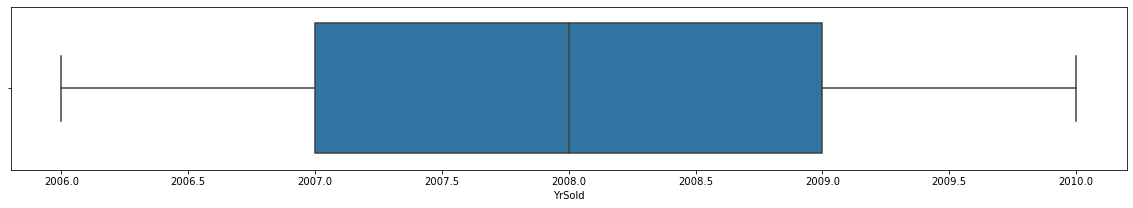

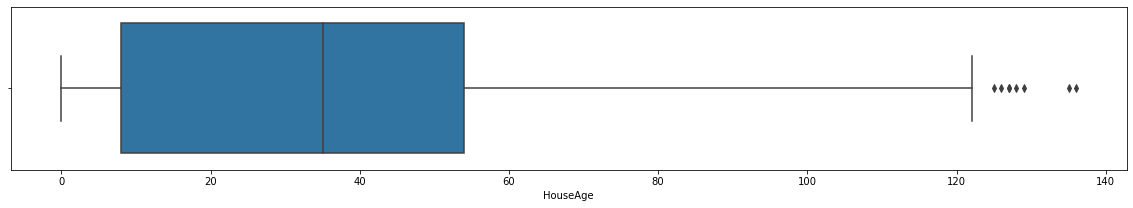

In [52]:
# Print boxplot for each numerical variable
for col in df_num_woSa:
    plt.figure(figsize=[20,3])
    sns.boxplot(df_num_woSa[col])
    plt.show()

We can see there are several outliers in at least 14 numerical variables. **Let's check how many data we would lose if we drop outliers.**

In [53]:
# Simulate outliers dropping
for col in df_num_woSa:
    df_num_woSa = remove_outliers(df_num_woSa,col)

left = len(df_num_woSa)
perc_total = round((len(df)-left)/len(df)*100,2)
print('\n{0} left records, {1}% lost of total'.format(left,perc_total))


558 left records, 61.78% lost of total


As our dataset is small and we'd loose a considerable amount of data, **we won't be dropping outliers** (and we'll use Standardization method to scale them as it is less affected by outliers than MinMax method).

#### Univariate analysis
As we did with categorical variables, we'll check numerical variables with more than 85% of records associated to one single value to delete those columns and reduce skewness.

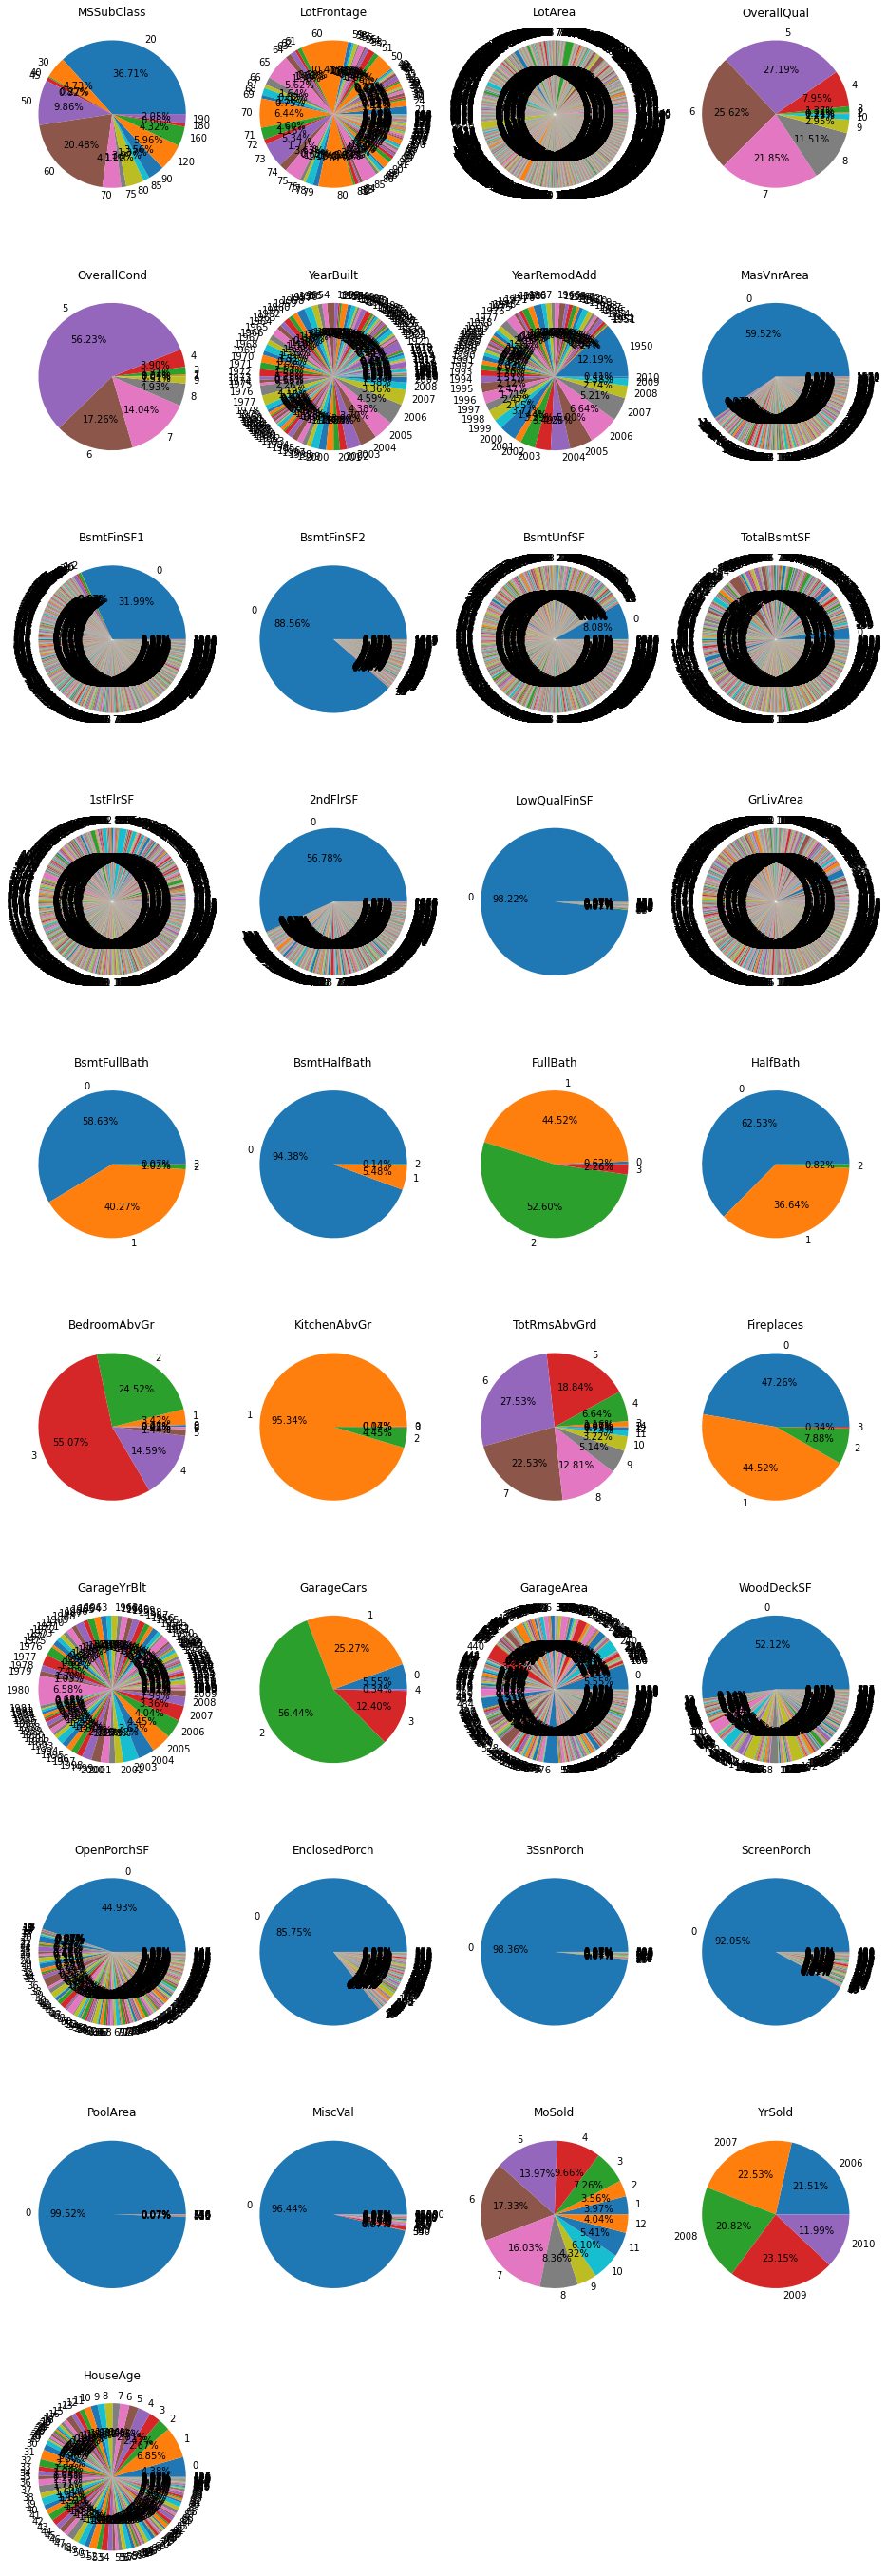

In [54]:
# Define graphs matrix properties
gr_cols = 4
gr_rows = math.ceil((len(df_num.columns)-1)/gr_cols)

# To show multiple graphs
fig, ax = plt.subplots(gr_rows, gr_cols, figsize=(16, 50))

# Create histograms
r = 0
c = 0
for col in df_num.columns:
    if col != 'SalePrice':
        agg_tbl = pd.pivot_table(df_num, index=col, values='SalePrice', aggfunc='count')
        ax[r,c].pie(agg_tbl['SalePrice'], labels = agg_tbl.index, autopct='%.2f%%')
        ax[r,c].title.set_text(col)
        if r < gr_rows and c < gr_cols-1:
            c += 1
        elif r < gr_rows:
            r += 1
            c = 0
# Handle empty graph to show
fig.delaxes(ax[gr_rows-1,1])
fig.delaxes(ax[gr_rows-1,2])
fig.delaxes(ax[gr_rows-1,3])
plt.show()

In [55]:
# List of numerical variables to remove
nums_to_remove = ['BsmtFinSF2','LowQualFinSF','BsmtHalfBath','KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

In [56]:
# Drop columns from df
df.drop(nums_to_remove,axis=1,inplace=True)

In [57]:
# Count columns by datatype
df.dtypes.value_counts()

int32     29
object    22
dtype: int64

**We have now 51 columns:**
- 22 categorical
- 29 numerical

Let's update the numerical variables dataframe.

In [58]:
# Filter out the categorical columns with integer data type
num_cols = list(df.select_dtypes(include=['int32']).columns)
print('Numerical columns: ',len(num_cols))

Numerical columns:  29


In [59]:
# Update df_num
df_num = df[num_cols]

In the *Handling outliers* section we showed box plots for all the numerical variables and saw we have a considerable amount of outliers.

As we are keeping the outliers and seeing a wide variety of distributions, we'll focus on analyzing their relationship with the target variable *SalePrice* as we'll get more valuable insights.

#### Bivariate analysis
Let's start printing the correlation between numerical variables.

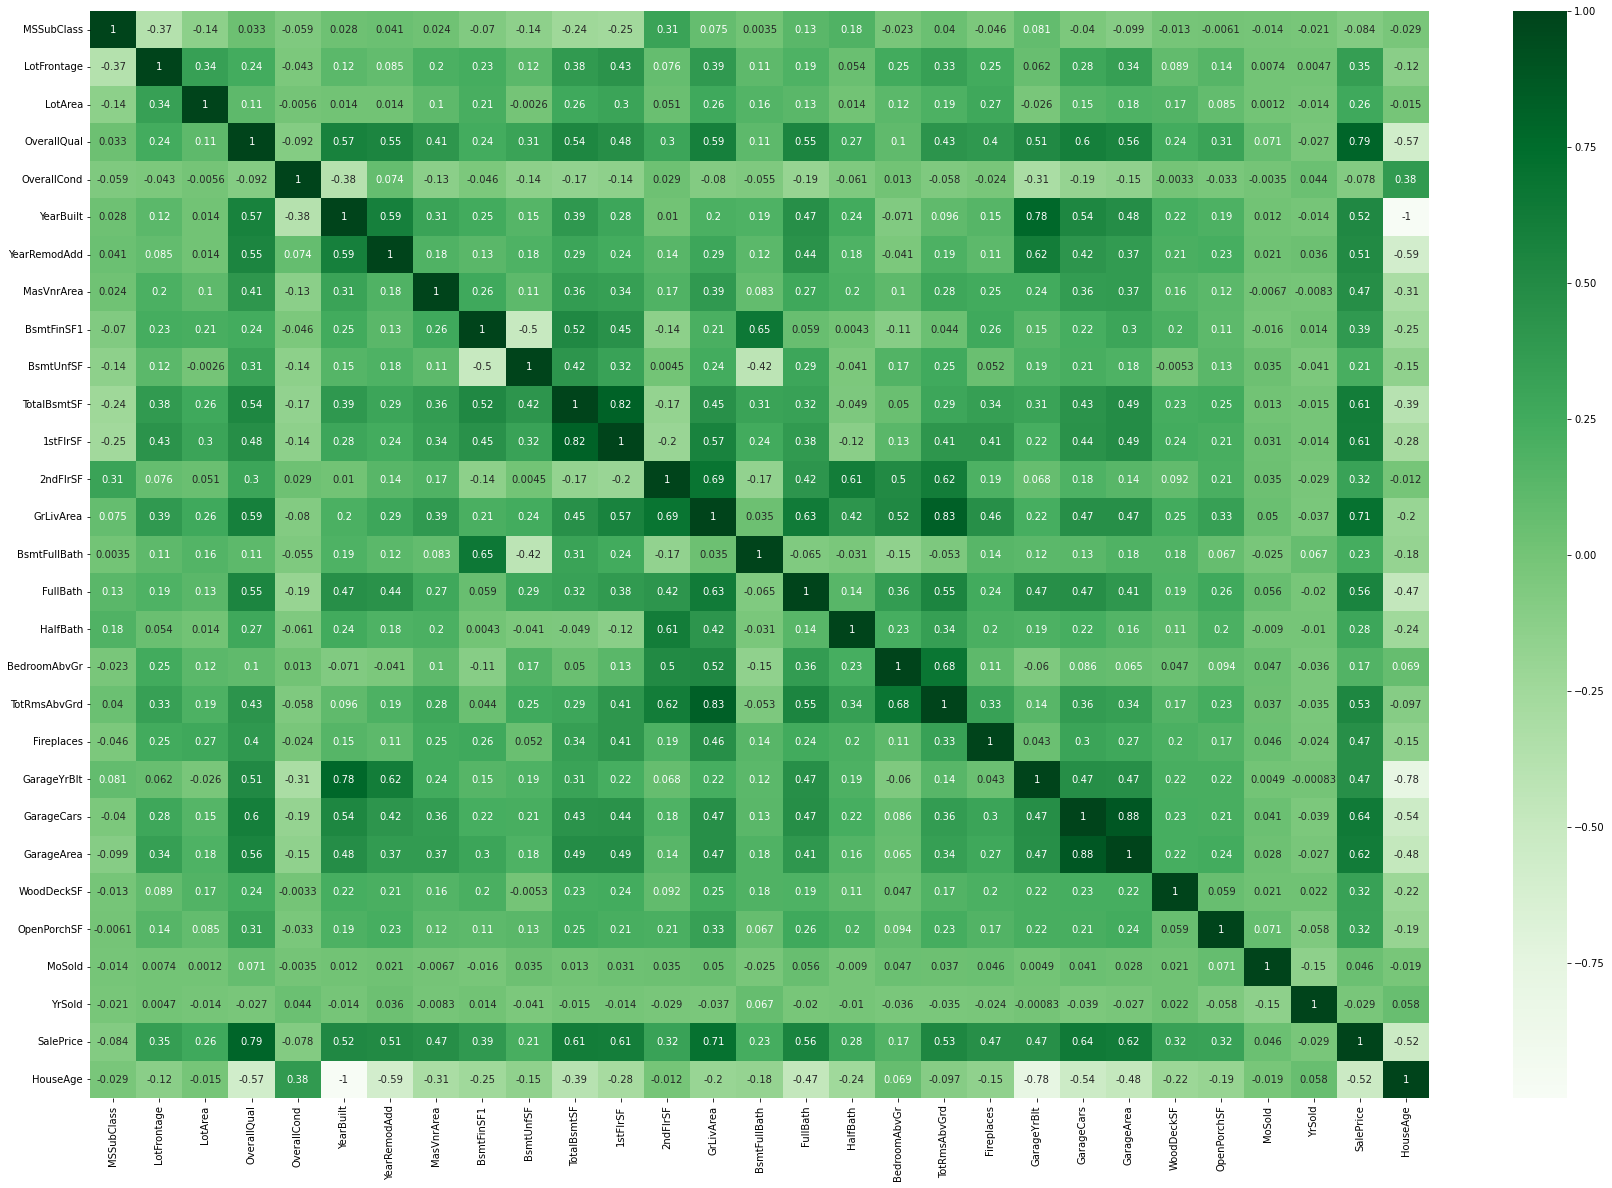

In [60]:
# Show numerical variables correlation
plt.figure(figsize = (30, 20))
sns.heatmap(df_num.corr(), annot = True, cmap='Greens')
plt.show()

From above heat map we can see that we have **some variables** (apart from with SalePrice) **highly positive correlated**. 
- **GarageCars** is correlated (0.88) with **Garage Area**, which makes sense as with more area we have more capacity for cars.
- **TotRmsAbvGrd** is correlated (0.83) with **GrLivArea**, which makes sense as the first one specifies the total rooms above grade and the second one the above grade living area: if we have more rooms above grade, we have more area above grade.
- **1stFirSF** is correlated (0.82) with **TotalBsmtSF**, which makes sense as the basement area supports almost completely (most cases) the first floor: higher the basement area, higher the area of the first floor. 
- **GarageYrBlt** is correlated (0.78) with **YearBuilt**, which makes sense as the garage is built (in almost all cases) at the same time the house is built.

We also have **some variables with high negative correlation**:
- **HouseAge** is correlated (-1) with **YearBuilt**, which is expected as we have derived the first one from the other one.
- **HouseAge** is correlated (-0.78) with **GarageYrBlt**, which might tell us that the garage was built around the same time as the house, and we derived the variable from YearBuilt.
- **HouseAge** is correlated (-0.57) with **Overallqual**, which is expected as with more years of a house, the less overall quality it has and viceversa.
- **HouseAge** is correlated (-0.54) with **GarageCars**, which might tell us that older houses have less area for cars or the other way around, new houses have more area for cars. This cannot be explained without the historical context.
- **HouseAge** is correlated (-0.52) with **SalePrice**, which is expected as with more years of a house, the lower the price it has and viceversa.
- **BsmtFinSF1** is correlated (-0.5) with **BsmnUnfSF**, probably one of the most obvious relationships as with more finished basement area the less unfinished basement area and viceversa.

If we take a threshold of 0.5 or -0.5, we have following **variables with high correlation with our target variable** *SalePrice*:
- OverallQual (0.79)
- GrLivArea (0.71)
- GarageCars (0.64) and GarageArea (0.62)
- TotalBsmtSF and 1stFlrSF (0.61)
- FullBath (0.56)
- TotRmsAbvGrd (0.53)

With above analysis **we have and idea of what variables we can expect in final models**.

**We'll drop the highly correlated independent variables that contribute the less to *SalePrice*.** In case of *TotalBsmtSF* against *1stFirSF*, we'll drop the basement related one as we could not have basement but as a house we'll always have a first floor.

In [61]:
# List of columns to drop
high_corr_cols = ['GarageCars','TotRmsAbvGrd','TotalBsmtSF','GarageYrBlt','BsmtUnfSF']

In [62]:
# Drop columns from df
df.drop(high_corr_cols,axis=1,inplace=True)

In [63]:
# Count columns by datatype
df.dtypes.value_counts()

int32     24
object    22
dtype: int64

**We have now 46 columns:**
- 22 categorical
- 24 numerical

Let's update the numerical variables dataframe.

In [64]:
# Filter out the categorical columns with integer data type
num_cols = list(df.select_dtypes(include=['int32']).columns)
print('Numerical columns: ',len(num_cols))

Numerical columns:  24


In [65]:
# Update df_num
df_num = df[num_cols]

Now we'll plot each variable against the target variable *SalePrice* to understand their relation and outseek the further need for variables transformation.

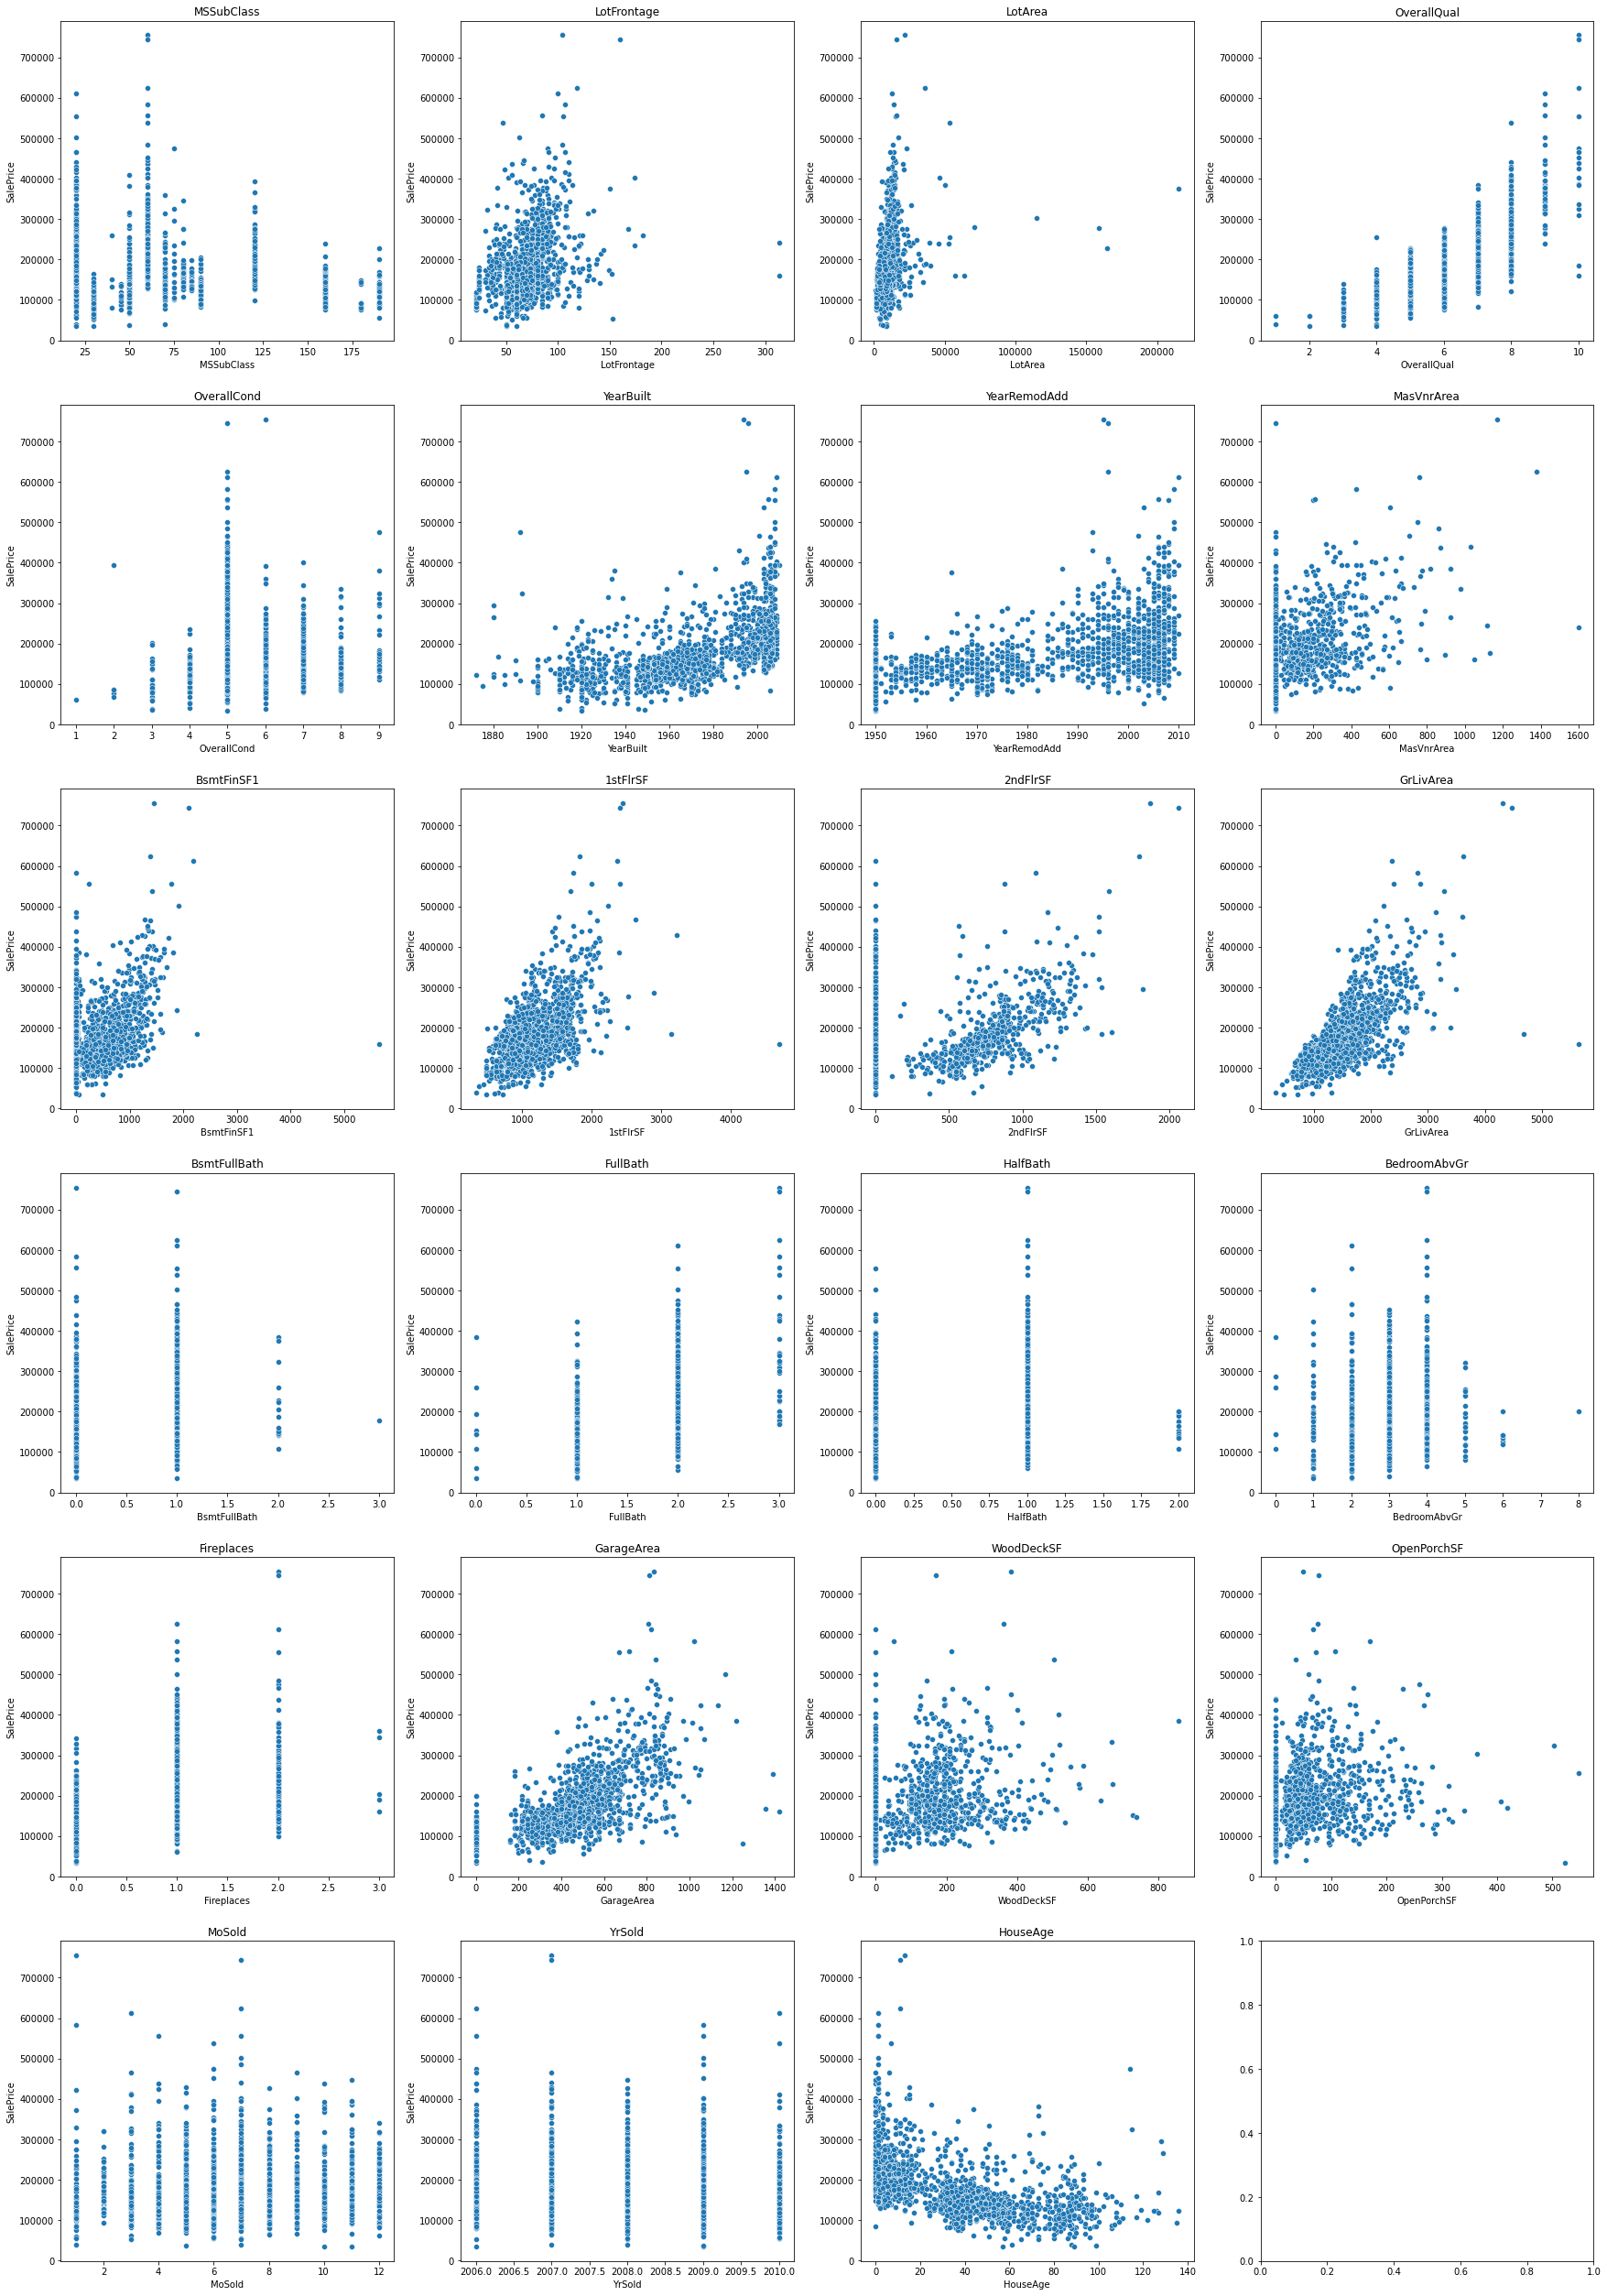

In [66]:
# Define graphs matrix properties
gr_cols = 4
gr_rows = math.ceil((len(df_num.columns)-1)/gr_cols)

# To show multiple graphs
fig, ax = plt.subplots(gr_rows, gr_cols, figsize=(30, 45))

# Create histograms
r = 0
c = 0
for col in df_num.columns:
    if col != 'SalePrice':
        sns.scatterplot(ax=ax[r,c], x = col, y = 'SalePrice', data = df_num)
        ax[r,c].title.set_text(col)
        if r < gr_rows and c < gr_cols-1:
            c += 1
        elif r < gr_rows:
            r += 1
            c = 0
plt.show()

From above scatter plots we can see different variables having a sort of linear relation with target variable *SalePrice*, so **using Linear Regression is justified at some point**. But the patterns are more exponential or logarithmics, so **we might want to transform variables to get a better relation (linear) between them**.

Also, we notice *HouseAge* is doing quite well in relation with *SalePrice* so we can drop the columns we derivated it from (and that are correlated):
- MoSold and YrSold
- YearBuilt and YearRemodAdd (this last being the same as construction date if no remodeling or additions)

In [67]:
# List of columns to drop
house_age_rel = ['MoSold','YrSold','YearBuilt','YearRemodAdd']

In [68]:
# Drop columns from df
df.drop(house_age_rel,axis=1,inplace=True)

In [69]:
# Count columns by datatype
df.dtypes.value_counts()

object    22
int32     20
dtype: int64

**We have now 42 columns:**
- 22 categorical
- 20 numerical

Let's update numerical variables list.

In [70]:
# Filter out the categorical columns with integer data type
num_cols = list(df.select_dtypes(include=['int32']).columns)
print('Numerical columns: ',len(num_cols))

df_num = df[num_cols]

Numerical columns:  20


## Data preparation for modeling

### Dummy variables
We'll create dummy variables for categorical columns, dropping first column to help reduce multicollinearity.

*MSSubClass* column has numerical values (and has been treated like that until now) but identifies the type of dwelling involved in the sale, i.e. it is categorical.

We'll cast it as string so get_dummies() function identifies it as categorical.

In [71]:
# Convert MSSubClass to string (categorical)
df['MSSubClass'] = df['MSSubClass'].astype(str)

df['MSSubClass'].describe()

count     1460
unique      15
top         20
freq       536
Name: MSSubClass, dtype: object

In [72]:
# Create dummy variables
df = pd.get_dummies(df, drop_first=True)
df.head()

LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0           65     8450            7            5         196         706   
1           80     9600            6            8           0         978   
2           68    11250            7            5         162         486   
3           60     9550            7            5           0         216   
4           84    14260            8            5         350         655   

   1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  ...  GarageFinish_Unf  \
0       856       854       1710             1  ...                 0   
1      1262         0       1262             0  ...                 0   
2       920       866       1786             1  ...                 0   
3       961       756       1717             1  ...                 1   
4      1145      1053       2198             1  ...                 0   

   Fence_GdWo  Fence_MnPrv  Fence_MnWw  Fence_NA  SaleCondition_AdjLand  \
0           0            0           0         1                      0   
1           0            0           0         1                      0   
2           0            0           0         1                      0   
3           0            0           0         1                      0   
4           0            0           0         1                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 168 columns]

In [73]:
# Count columns by datatype
df.dtypes.value_counts()

uint8    149
int32     19
dtype: int64

In [74]:
# Filter out the categorical columns with integer data type
num_cols = list(df.select_dtypes(include=['int32']).columns)
print('Numerical columns: ',len(num_cols))

df_num = df[num_cols]

Numerical columns:  19


## Model building and evaluation

### Linear Regression model analysis
We are going to create a Linear Regression model to **identify if there is a variable transformation we need to do** better results (with same Linear Regression or another regularized model).

#### Creating train and test sets
The first basic step for regression is performing a train-test split. For this we'll use SKLearn function *train_test_split*.

In [75]:
# We specify the random state so that the train and test data set always have the same rows count, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

# Prin the test and train dataframes shapes
print('Train set shape: ', df_train.shape)
print('Test set shape: ', df_test.shape)

Train set shape:  (1021, 168)
Test set shape:  (438, 168)


#### Rescaling the features
It is important to rescale the variables so that they have a comparable scale. **We'll use standardization method**.

In [76]:
# Keep numerical columns without targe variable and MSSubClass
num_cols.remove('SalePrice')

In [77]:
# Create an object for scaler
scaler = StandardScaler()

# Rescaling for training set
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

# Rescaling for test set
df_test[num_cols] = scaler.transform(df_test[num_cols])

In [78]:
# Check rescaled features
df_train.head()

LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
210     -0.136366 -0.473765    -0.779861     0.383154   -0.558025    0.043512   
318      0.889676 -0.056845     0.649651    -0.533005    0.809137    1.160345   
239     -0.805523 -0.169324    -0.065105    -1.449164   -0.558025   -0.761296   
986     -0.493250 -0.502297    -0.065105     2.215472   -0.558025   -0.963574   
1416    -0.448639  0.082905    -1.494617     0.383154   -0.558025   -0.963574   

      1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  ...  GarageFinish_Unf  \
210  -0.765065 -0.787597  -1.228053      1.066863  ...                 0   
318   0.511914  2.140556   2.123103      1.066863  ...                 0   
239  -0.930972  0.795996  -0.056465     -0.837450  ...                 1   
986  -0.420683  0.669584   0.221858     -0.837450  ...                 1   
1416  0.195183  1.611926   1.453624     -0.837450  ...                 1   

      Fence_GdWo  Fence_MnPrv  Fence_MnWw  Fence_NA  SaleCondition_AdjLand  \
210            0            0           0         1                      0   
318            0            0           0         1                      0   
239            0            1           0         0                      0   
986            0            0           0         1                      0   
1416           0            0           0         1                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
210                      0                     0                     1   
318                      0                     0                     1   
239                      0                     0                     1   
986                      0                     0                     1   
1416                     0                     0                     1   

      SaleCondition_Partial  
210                       0  
318                       0  
239                       0  
986                       0  
1416                      0  

[5 rows x 168 columns]

In [79]:
# Check rescaled features
df_test.head()

LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
1436    -0.448639 -0.144189    -1.494617     0.383154   -0.558025    0.361992   
57       0.845065  0.112505     0.649651    -0.533005   -0.558025   -0.963574   
780     -0.314808 -0.253368     0.649651    -0.533005   -0.355087   -0.963574   
382      0.398960 -0.120412     0.649651    -0.533005   -0.558025   -0.963574   
1170     0.265129 -0.058786    -0.065105     0.383154   -0.558025    0.159714   

      1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  ...  GarageFinish_Unf  \
1436 -0.765065 -0.787597  -1.228053     -0.837450  ...                 1   
57   -0.775120  1.189021   0.381706     -0.837450  ...                 0   
780   0.212779 -0.787597  -0.496515     -0.837450  ...                 0   
382  -0.576535  1.184425   0.526509     -0.837450  ...                 0   
1170 -0.126576 -0.787597  -0.750391      1.066863  ...                 0   

      Fence_GdWo  Fence_MnPrv  Fence_MnWw  Fence_NA  SaleCondition_AdjLand  \
1436           1            0           0         0                      0   
57             0            0           0         1                      0   
780            0            0           0         1                      0   
382            0            0           0         1                      0   
1170           0            0           0         0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1436                     0                     0                     1   
57                       0                     0                     1   
780                      0                     0                     1   
382                      0                     0                     1   
1170                     0                     0                     1   

      SaleCondition_Partial  
1436                      0  
57                        0  
780                       0  
382                       0  
1170                      0  

[5 rows x 168 columns]

#### Dividing into X and Y sets for the model building
Now we'll separate the dependent variables from the independent one.

In [80]:
# Train set
y_train = df_train.pop('SalePrice')
X_train = df_train

In [81]:
#Test set
y_test = df_test.pop('SalePrice')
X_test = df_test

#### Building the model and predicting

In [82]:
# Building the regression model
lreg = LinearRegression()
lreg.fit(X_train,y_train)

LinearRegression()

In [83]:
# Predictions on the training set
y_train_pred = lreg.predict(X_train)

In [84]:
# Predictions on the test set
y_test_pred = lreg.predict(X_test)

#### Model prediction evaluation
We have trained and predicted with a Linear Regression model, now we'll obtain the evaluation metrics for it

In [85]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [86]:
# Get scoring metrics
metrics_df = get_scoreMetrics(y_train, y_train_pred, y_test, y_test_pred, len(X_train.columns))
metrics_df.set_index([pd.Index(['Train','Test'])])

R-squared             Adj. R-squared  \
Train                      0.887                      0.865   
Test  -539306373289496281088.000 -644891560088260444160.000   

                                         RSS  \
Train                       722342611091.709   
Test  1520149632088890164357691187658752.000   

                                      MSE                 RMSE  
Train                       707485417.328            26598.598  
Test  3470661260476918296569148604416.000 1862971084176273.000

We can see that in the **train set** the model can explain ~89% of the variance in the data and R-squared with Adj. R-squared have similar values, but **RSS, MSE, and RMSE values are high**, which indicates the model does not fit well the data.

For **test set** we are even getting a **negative value of R-squared**, which means the model fits worse than a horizontal line (and all other values are really high!) and thus the model is overfitting. **We clearly see we cannot rely on this model**.

#### Residual analysis on the test data
So, now to check if the error terms are normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

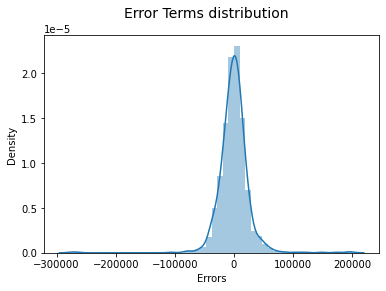

In [87]:
# Plot the histogram of the error terms
fig = plt.figure()
residuals = y_train - y_train_pred
sns.distplot(residuals)
fig.suptitle('Error Terms distribution', fontsize = 14)
plt.xlabel('Errors', fontsize = 10)
plt.show()

We can see that the **errors have a normal distribution**, with median and mean centered at value zero. But we need to check the residuals independency.

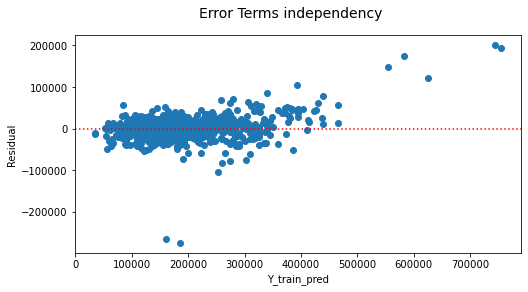

In [88]:
# Plot error terms
fig = plt.figure(figsize=(8,4))
plt.scatter(y_train,residuals)
plt.axhline(y=0, color='r', linestyle=':')
fig.suptitle('Error Terms independency', fontsize=14)
plt.xlabel('Y_train_pred', fontsize=10)
plt.ylabel('Residual', fontsize=10) 
plt.show()

From above graph we can see the **errors** do follow a pattern, they **are condensed in an area and variance increments towards the right side of the plot**.

With these information we cannot rely in the significance of the model variables coefficients and **we can talk about transforming the variables**.

#### Target variable transformation
Le't take a look into *SalePrice* distribution.

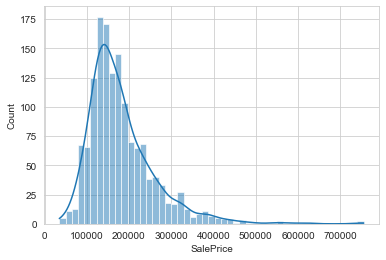

In [89]:
# Print distribution plot
sns.set_style("whitegrid")
sns.histplot(data=df, x='SalePrice', kde=True)
plt.show()

We can see that the target variable is right-skewed. In order to have a better distribution we could remove outliers or transform the variable to have it centered like a normal distribution.

Also, in numerical analysis we saw different variables having a not so much linear relationship with *SalePrice*, and our residuals in Linear Regression model follow a certain pattern with increasing variance towards the right side.

**We'll transform target variable** and print again its distribution.

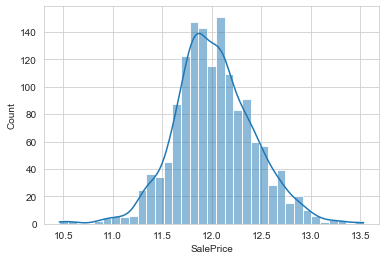

In [90]:
# Apply log transformation
df['SalePrice'] = np.log1p(df['SalePrice'])
# Into our numerical only df too
df_num['SalePrice'] = np.log1p(df_num['SalePrice'])

# Print distribution plot
sns.set_style("whitegrid")
sns.histplot(data=df, x='SalePrice', kde=True)
plt.show()

Now let's plot again the *SalePrice* against numerical variables.

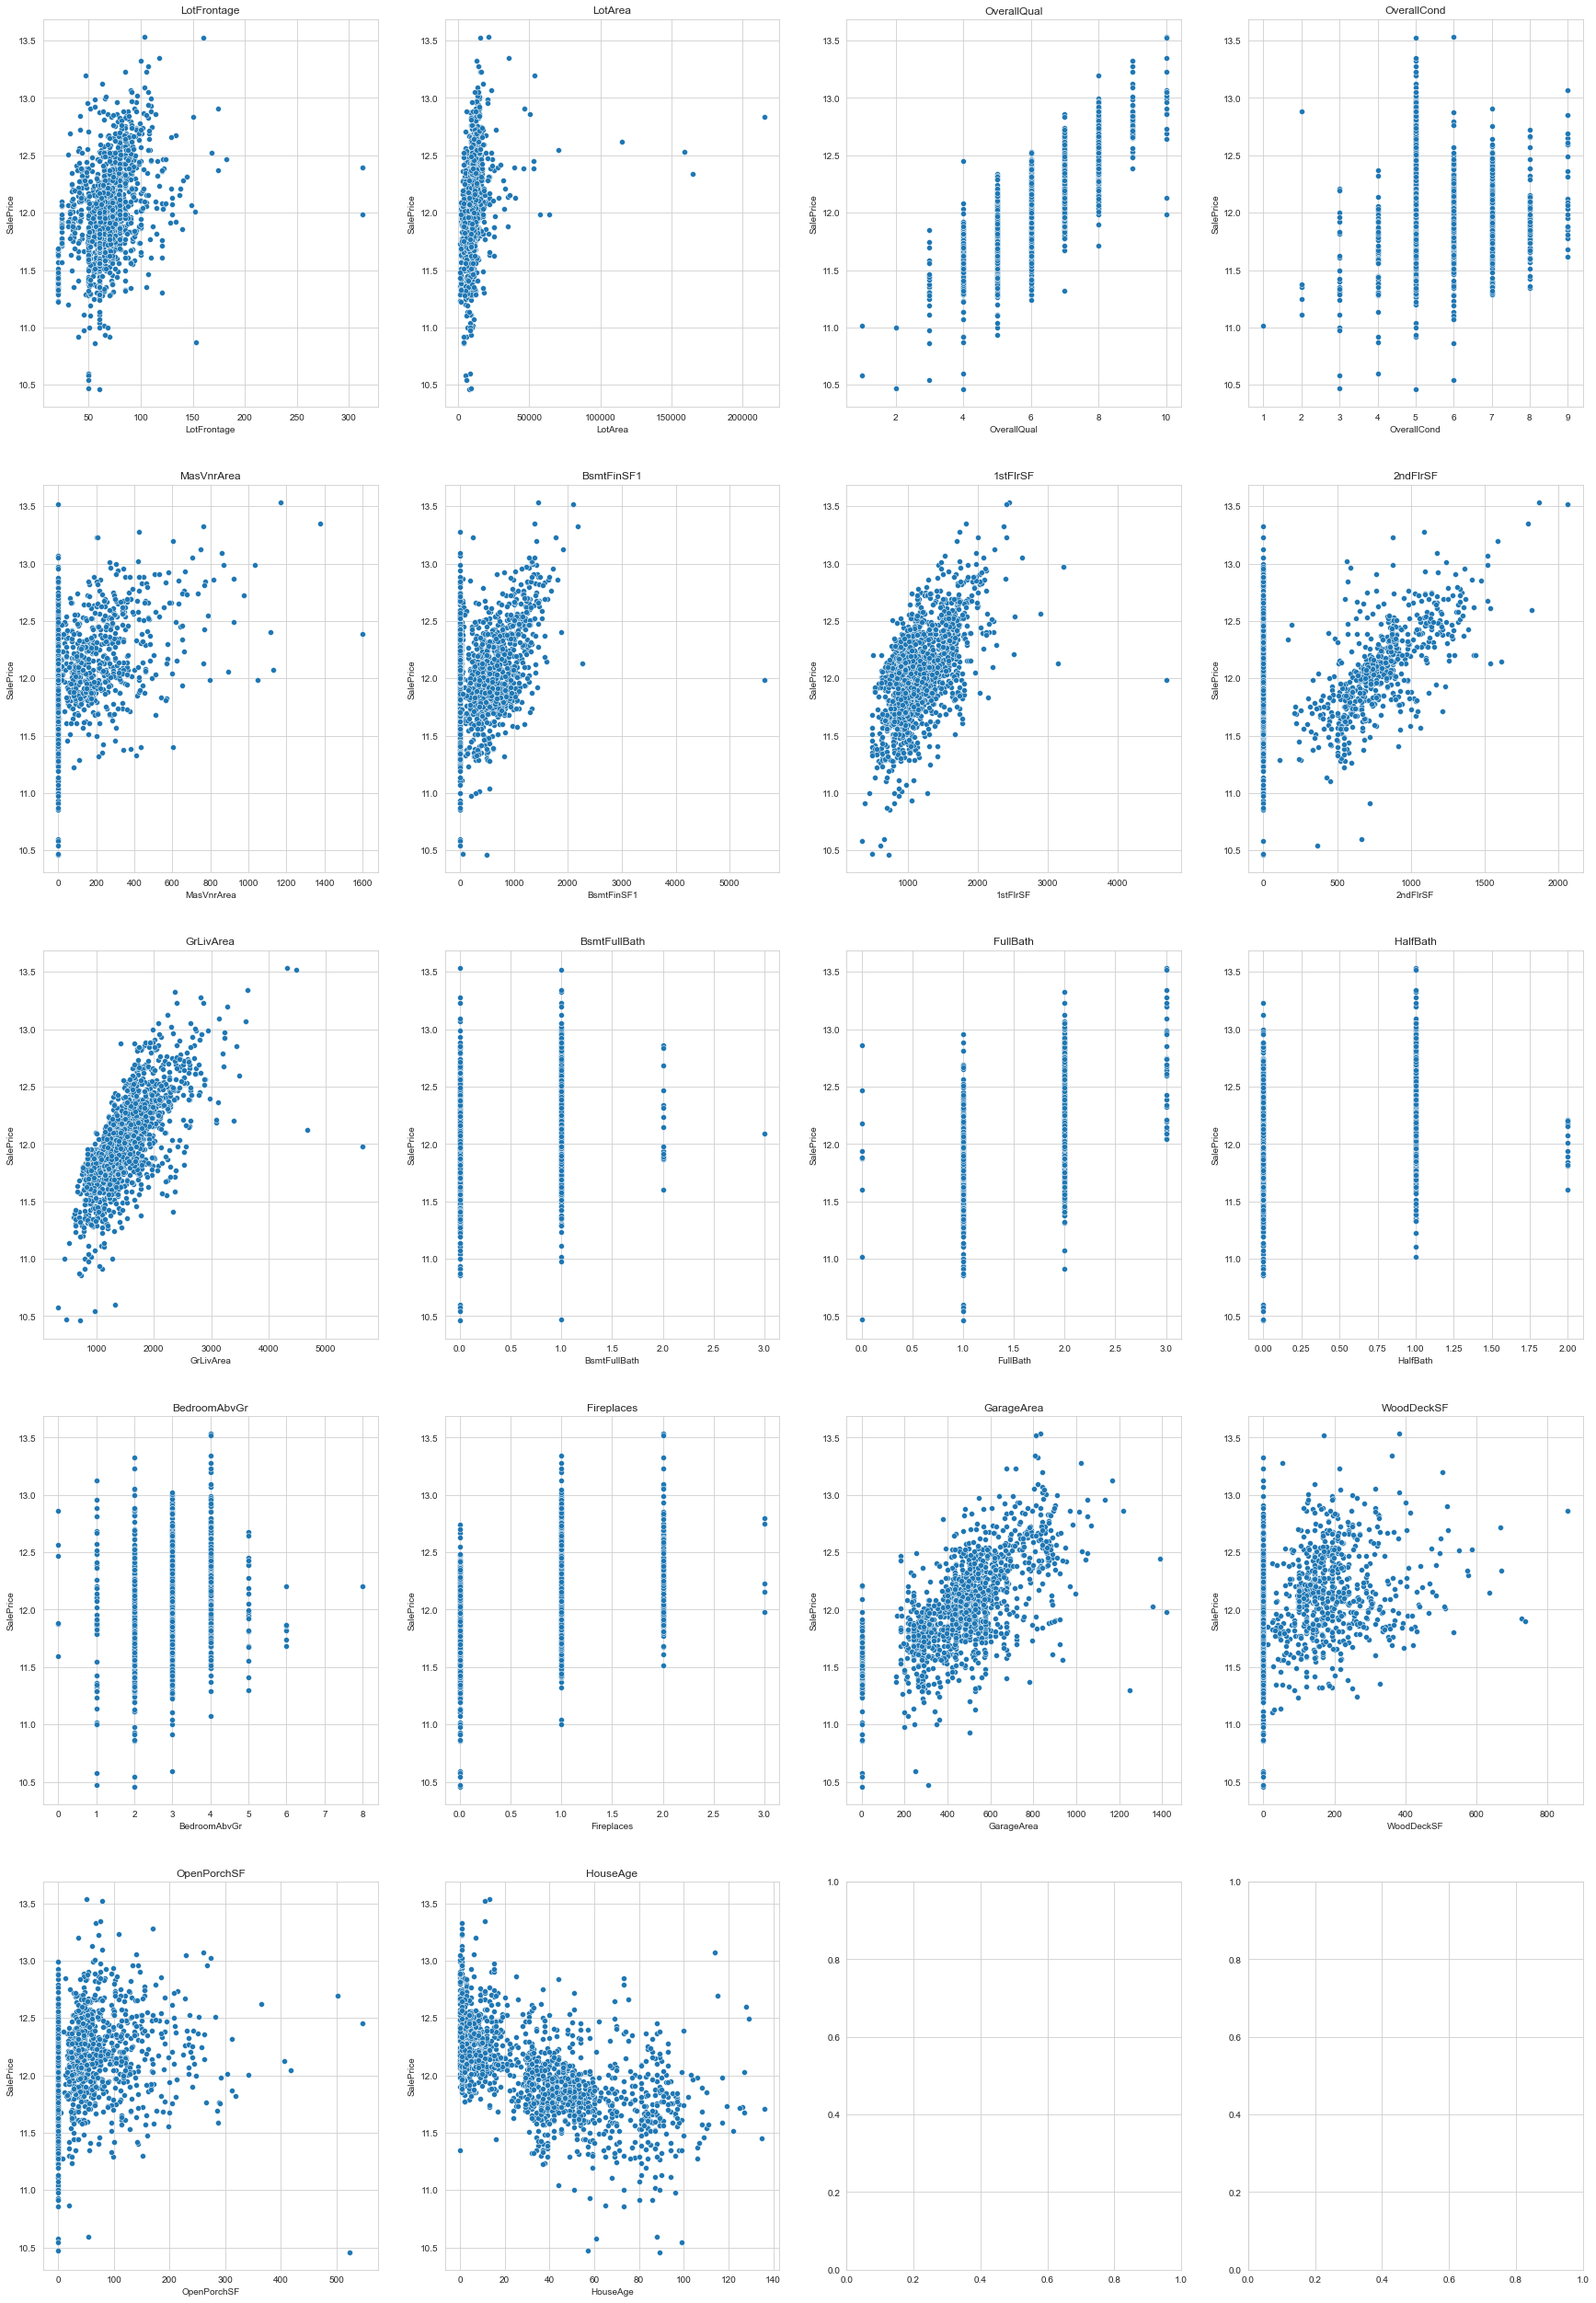

In [91]:
# Define graphs matrix properties
gr_cols = 4
gr_rows = math.ceil((len(df_num.columns)-1)/gr_cols)

# To show multiple graphs
fig, ax = plt.subplots(gr_rows, gr_cols, figsize=(30, 45))

# Create histograms
r = 0
c = 0
for col in df_num.columns:
    if col != 'SalePrice':
        sns.scatterplot(ax=ax[r,c], x = col, y = 'SalePrice', data = df_num)
        ax[r,c].title.set_text(col)
        if r < gr_rows and c < gr_cols-1:
            c += 1
        elif r < gr_rows:
            r += 1
            c = 0
plt.show()

We can see that the **linear relationship between numerical variables and target variable improved** a bit.

The **transformation** we just did is called a **"log-level" regression**, were the numervical variables are left in their normal scales. The model should be interpreted as follows:

*A unit change in feature X_i will cause a change of 100 * Beta_i*.

Where Beta_i is the exponential minus one of the feature coefficient.

#### Running again Linear Regression model
Let's check how the target variable transformation affects a Linear Regression model.

In [92]:
# We specify the random state so that the train and test data set always have the same rows count, respectively
np.random.seed(0)
df_train_trans, df_test_trans = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [93]:
# Create an object for scaler
scaler = StandardScaler()

# Rescaling for training set
df_train_trans[num_cols] = scaler.fit_transform(df_train_trans[num_cols])

# Rescaling for test set
df_test_trans[num_cols] = scaler.transform(df_test_trans[num_cols])

In [94]:
# Train set
y_train_trans = df_train_trans.pop('SalePrice')
X_train_trans = df_train_trans

In [95]:
#Test set
y_test_trans = df_test_trans.pop('SalePrice')
X_test_trans = df_test_trans

In [96]:
# Building the regression model
lreg_trans = LinearRegression()
lreg_trans.fit(X_train_trans,y_train_trans)

LinearRegression()

In [97]:
# Predictions on the training set
y_train_pred_trans = lreg_trans.predict(X_train_trans)

In [98]:
# Predictions on the test set
y_test_pred_trans = lreg_trans.predict(X_test_trans)

In [99]:
# Get scoring metrics
metrics_df = get_scoreMetrics(y_train_trans, y_train_pred_trans, y_test_trans, y_test_pred_trans, len(X_train_trans.columns))
metrics_df.set_index([pd.Index(['Train','Test'])])

R-squared              Adj. R-squared  \
Train                       0.917                       0.901   
Test  -6148941476072244903936.000 -7352778787331406561280.000   

                               RSS                        MSE            RMSE  
Train                       13.272                      0.013           0.114  
Test  443139503132926013341696.000 1011734025417639329792.000 31807766746.781

We can see that in the **train set** the model can explain ~92% of the variance in the data (Adj. R-squared keeps similar to R-squared).

In below two plots we see residuals are more normally distributed than before and residuals are randomly sparsed, but for **test set** we are STILL getting a **negative value of R-squared**, which means the model fits worse than a horizontal line (and all other values are really high!) and thus the model is overfitting. **We clearly see we cannot rely on a linear regression model**.

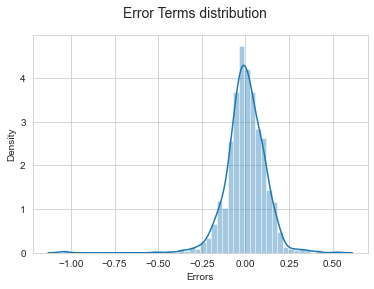

In [100]:
# Plot the histogram of the error terms
fig = plt.figure()
residuals_trans = y_train_trans - y_train_pred_trans
sns.distplot(residuals_trans)
fig.suptitle('Error Terms distribution', fontsize = 14)
plt.xlabel('Errors', fontsize = 10)
plt.show()

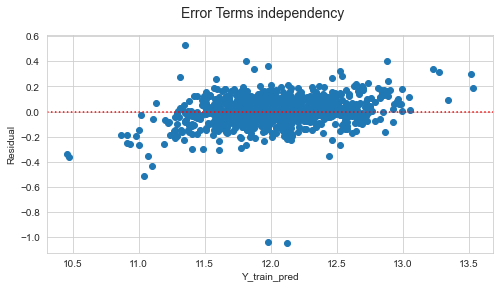

In [101]:
# Plot error terms
fig = plt.figure(figsize=(8,4))
plt.scatter(y_train_trans,residuals_trans)
plt.axhline(y=0, color='r', linestyle=':')
fig.suptitle('Error Terms independency', fontsize=14)
plt.xlabel('Y_train_pred', fontsize=10)
plt.ylabel('Residual', fontsize=10) 
plt.show()

So far we have seen the need of building a model with another technique. **We'll create and review regularized models with Ridge and Lasso Regressions.**

### Building a Regularized model with Lasso Regression
As Lasso Regression performs feature selection, we won't use Recursive Feature Elimination (RFE) for any reason.

#### Finding the optimal lambda
Choosing the right lambda is crucial so as to reduce only the variance in the model, without compromising much on identifying the underlying patterns, i.e., the bias.

To find the optimal alpha we need to try different values for a given score metric, for the purpose we'll use **GridSearchCV()**. We'll choose the **Negative MAE (Mean Absolute Error) metric for scoring**.

**Why Negative MAE?** After training, GridSearchCV() ranks all the algorithms (estimators) and tells you which one is the best. Now when you use an error function, estimator with higher score will be ranked higher by sklearn, which is not true in the case of MAE (along with MSE and a few others).
To deal with this, the library flips the sign of error, so the highest MAE will be ranked lowest and vice versa.

Let's **run GridSearchCV()** to get the optimal lambda for Negative MAE score.

Let's define a **list of lambdas** to choose from.

In [102]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                    4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

In [103]:
# Define Lasso model
lasso = Lasso()

# cross validation
folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
lasso_model_cv.fit(X_train_trans, y_train_trans) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [104]:
# Printing the best hyperparameter alpha
alpha_lasso = lasso_model_cv.best_params_['alpha']
print('Best alpha: ',alpha_lasso)

Best alpha:  0.001


Let's plot the alpha values against the Negative MAE for first values of alpha, to see how they relate for train and test data.

In **red line** the value for alpha selected by Lasso Regression.

In [105]:
lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
# Select alpha less than or equal to 50
lasso_cv_results = lasso_cv_results[lasso_cv_results['param_alpha']<=0.05]

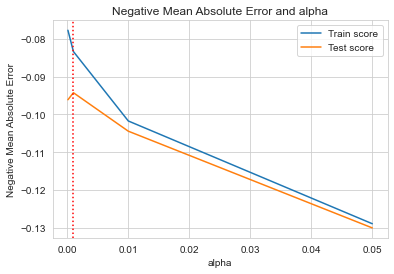

In [106]:
# Plotting mean test and train scores with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.axvline(x = alpha_lasso, color = 'r', linestyle=':')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['Train score', 'Test score'], loc='upper right')
plt.show()

#### Building the model and predicting
According to the GridSearch results the **best alpha is 0.001**. Let's **create a model with this alpha** to analyse predictions.

In [107]:
#Fitting Lasso model for alpha = 0.0001
lasso = Lasso(alpha=alpha_lasso)

lasso.fit(X_train_trans, y_train_trans)

Lasso(alpha=0.001)

In [108]:
# Prediction on train and test sets
y_train_pred_lasso = lasso.predict(X_train_trans)
y_test_pred_lasso = lasso.predict(X_test_trans)

#### Model prediction evaluation

In [109]:
# Get scoring metrics
lasso_df = get_scoreMetrics(y_train_trans, y_train_pred_lasso, y_test_trans, y_test_pred_lasso, len(X_train_trans.columns))
lasso_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.897           0.876 16.599 0.016 0.128
Test       0.880           0.857  8.626 0.020 0.140

We can see that in the **train set** the model can explain **~90% of the variance** in the data. In **test set** it explains **88% of the variance**. These are great results as we also have Adj. R-squared close to R-squared and low values for RSS, MSE, and RMSE.

This model  performs better than a Linear Regression model.

#### Chosen parameters review
We'll check the coefficients of the parameters to understand which ones affect the most the target variable.

Let's remember that the **model should be interpreted as follows**:

*A unit change in feature X_i will cause a change of 100 * Beta_i*.

Where Beta_i is the exponential minus one of the feature coefficient.

In [110]:
# Get Lasso model selected features
lasso_coeffs_df = get_selectedFeatures(lasso)

# Print selected features (coefficients different from zero)
print('Total columns: ', len(df.columns))
print('Total selected columns by Lasso: ', len(lasso_coeffs_df))
lasso_coeffs_df.head(11)

Total columns:  168
Total selected columns by Lasso:  69


Feature  Coefficient  Exponential*100 value
0               Constant       11.934           15243498.250
1   Neighborhood_Crawfor        0.118                 12.491
2   Neighborhood_NridgHt        0.108                 11.360
3              GrLivArea        0.102                 10.760
4            OverallQual        0.100                 10.484
5   Neighborhood_Somerst        0.090                  9.428
6   Neighborhood_ClearCr        0.076                  7.853
7        BsmtExposure_NA       -0.077                 -7.448
8         MSSubClass_160       -0.069                 -6.639
9               HouseAge       -0.068                 -6.583
10  Neighborhood_NoRidge        0.062                  6.439

From 155 columns we ended up having **69 columns only**.

We can see that the **top 10 predictor variables** are:
1. *Neighborhood_Crawfor*. House being in Crawford neighborhood. A unit change in this variable increases by 12.49% the house price, which means is considered a "good neighborhood" for living.
2. *Neighborhood_NridgHt*. House being in Northridge Heights neighborhood. A unit change in this variable increases by 11.36% the house price, which means is considered a "good neighborhood" for living.
3. *GrLivArea*. A unit change in this variable increases by 10.76% the house price. The higher the above grade living area square feet, the highest the price.
4. *OverallQual*. A unit change in this variable increases by 10.48% the house price. The greater the overall quality, the greater the price.
5. *Neighborhood_Somerst*. House being in Somerset neighborhood. A unit change in this variable increases by 9.5424% the house price, which means is considered a "good neighborhood" for living.
6. *Neighborhood_ClearCr*. House being in Clear Creek neighborhood. A unit change in this variable increases by 7.85% the house price, which means is considered a "good neighborhood" for living.
7. *BsmtExposure_NA*. Having no basement. A unit change in this variable decreases by 7.44% the house price.
8. *MSSubClass_160*. The type of dwelling involved in the sale is '2-STORY PUD - 1946 & NEWER'. A unit change in this variable decreases by 6.63% the house price.
9. *HouseAge*. A unit change in this variable decreases by 6.58% the house price. This means that the older the house the lower the price.
10. *Neighborhood_NoRidge*. House being in Northridge neighborhood. A unit change in this variable increases by 6.43% the house price, which means is considered a "good neighborhood" for living.

#### Exercise: doubling the value of alpha
* What will be the changes in the model if we double the value of alpha?
* What will be the most important predictor variables after the change is implemented?

In [111]:
#Fitting Lasso model for alpha = 0.4*2
lasso_double = Lasso(alpha=alpha_lasso*2)

lasso_double.fit(X_train_trans, y_train_trans)

Lasso(alpha=0.002)

In [112]:
# Prediction on train and test sets
y_train_pred_lasso_double = lasso_double.predict(X_train_trans)
y_test_pred_lasso_double = lasso_double.predict(X_test_trans)

In [113]:
# Get scoring metrics
metrics_df = get_scoreMetrics(y_train_trans, y_train_pred_lasso_double, y_test_trans, y_test_pred_lasso_double, len(X_train_trans.columns))
metrics_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.881           0.858 19.031 0.019 0.137
Test       0.877           0.853  8.875 0.020 0.142

We can see that in the **train set** the model can explain **~88% of the variance** in the data, and in **test set** it can explain **around the same of the variance**. The test R-squared and Adj. R-squared values decreased a little from previous modeling with alpha 0.001.

Let's check the top predictor variables.

In [114]:
# Get Lasso model selected features
lasso_double_coeffs_df = get_selectedFeatures(lasso_double)

# Print selected features (coefficients different from zero)
print('Total columns: ', len(df.columns))
print('Total selected columns by Lasso: ', len(lasso_double_coeffs_df))
lasso_double_coeffs_df.head(11)

Total columns:  168
Total selected columns by Lasso:  52


Feature  Coefficient  Exponential*100 value
0               Constant       11.947           15433695.655
1            OverallQual        0.113                 11.997
2              GrLivArea        0.102                 10.716
3   Neighborhood_Crawfor        0.082                  8.502
4   Neighborhood_NridgHt        0.067                  6.887
5               HouseAge       -0.066                 -6.424
6            OverallCond        0.051                  5.264
7          MSSubClass_20        0.049                  5.033
8   Neighborhood_Somerst        0.049                  4.980
9        BsmtExposure_Gd        0.046                  4.697
10        MSSubClass_160       -0.048                 -4.677

In this case the **coefficients are smaller** and percentage change in *SalePrice* is smaller too; the **selected features drop from 67 to 52**. 

We have **different top 10 columns and common ones in different order of affection to the *SalePrice***. *OverallQual* and *GrLivArea* affect the most the house price. *OverallCond*, *MSSubClass_20*, and *BsmtExposure_Gd* are the new columns.

#### Exercise: unavailable columns in incoming data
After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. 

Which are the five most important predictor variables now?

In [115]:
# List of top 5 predictor variables
top_features = list(lasso_coeffs_df.head(6)['Feature'])
top_features.remove('Constant')

In [116]:
# Update train and test sets with selected columns only
X_train_noTop = X_train_trans.loc[:, ~X_train_trans.columns.isin(top_features)]
X_test_noTop = X_test_trans.loc[:, ~X_test_trans.columns.isin(top_features)]

In [117]:
# Define Lasso model
lasso_noTop = Lasso()

# cross validation
folds = 5
lasso_noTop_model_cv = GridSearchCV(estimator = lasso_noTop, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
lasso_noTop_model_cv.fit(X_train_noTop, y_train_trans) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [118]:
# Printing the best hyperparameter alpha
alpha_lasso_noTop = lasso_noTop_model_cv.best_params_['alpha']
print('Best alpha: ',alpha_lasso_noTop)

Best alpha:  0.001


In [119]:
#Fitting Lasso model for alpha = 0.0001
lasso_noTop = Lasso(alpha=alpha_lasso_noTop)

lasso_noTop.fit(X_train_noTop, y_train_trans)

Lasso(alpha=0.001)

In [120]:
# Prediction on train and test sets
y_train_pred_lasso_noTop = lasso_noTop.predict(X_train_noTop)
y_test_pred_lasso_noTop = lasso_noTop.predict(X_test_noTop)

In [121]:
# Get scoring metrics
metrics_df = get_scoreMetrics(y_train_trans, y_train_pred_lasso_noTop, y_test_trans, y_test_pred_lasso_noTop, len(X_train_trans.columns))
metrics_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.885           0.862 18.509 0.018 0.135
Test       0.861           0.834  9.985 0.023 0.151

We can see that in the **train set** the model can explain **~88% of the variance** in the data, and in **test set** it can explain **~86% of the variance**. The test R-squared and Adj. R-squared values decreased a little from previous modeling with top feature variables available.

Let's check the top 5 predictor variables.

In [122]:
# Get Lasso model selected features
lasso_noTop_coeffs_df = get_selectedFeatures(lasso_noTop)

# Print selected features (coefficients different from zero)
print('Total columns: ', len(df.columns))
print('Total selected columns by Lasso: ', len(lasso_noTop_coeffs_df))
lasso_noTop_coeffs_df.head(6)

Total columns:  168
Total selected columns by Lasso:  74


Feature  Coefficient  Exponential*100 value
0              Constant       12.086           17740567.944
1         MSSubClass_50        0.114                 12.064
2       Foundation_Slab       -0.128                -12.015
3            BsmtFinSF1        0.104                 10.949
4              1stFlrSF        0.103                 10.827
5  Neighborhood_ClearCr       -0.109                -10.327

### Building a Regularized model with Ridge Regression

#### Recursive Feature Elimination (RFE)
As Ridge Regression does not perform feature selection, we'll use it with RFE to narrow down the number of features in final model.

We saw that Lasso Regression with optimal alpha value left 67 columns, and we want to be able to compare it against Ridge Regression. We'll select **number of variables equal to 69**. 

In [123]:
# Run RFE with the output number of variables equal to 69
ridge_rfe = Ridge()
ridge_rfe.fit(X_train_trans, y_train_trans)

rfe = RFE(ridge_rfe, 69)             
rfe = rfe.fit(X_train_trans, y_train_trans)

In [124]:
# Print the columns selected by RFE
selected_cols = X_train.columns[rfe.support_]
print('Total selected columns by RFE: ',len(selected_cols))
selected_cols

Total selected columns by RFE:  69


Index(['OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', 'HouseAge',
       'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_20', 'MSSubClass_30',
       'MSSubClass_40', 'MSSubClass_50', 'MSSubClass_70', 'MSSubClass_75',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR3', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Sawyer',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'BldgType_Twnhs', 'HouseStyle_2.5Fin', 'RoofStyle_Mansard',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_VinylSd',
       'Exterior2nd_BrkFace', 'Exterior2nd_CmentBd', 'Exterior2nd_Stucco',
       'Exterior2nd_Wd Shng', 'Exter

In [125]:
# Update train and test sets with selected columns only
X_train_rfe = X_train_trans[selected_cols]
X_test_rfe = X_test_trans[selected_cols]

#### Finding the optimal lambda

Now let's **run GridSearchCV()** to get the optimal lambda for Negative MAE score.

In [126]:
# Define Ridge model
ridge = Ridge()

# cross validation
folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train_rfe, y_train_trans) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [127]:
# Printing the best hyperparameter alpha
alpha_ridge = ridge_model_cv.best_params_['alpha']
print('Best alpha: ',alpha_ridge)

Best alpha:  6.0


Let's plot the alpha values against the Negative MAE for first values of alpha, to see how they relate for train and test data.

In **red line** the value for alpha selected by Ridge Regression.

In [128]:
ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
# Select alpha less than or equal to 50
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=100]

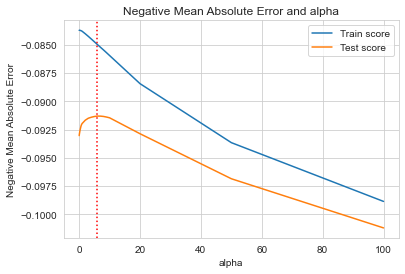

In [129]:
# Plotting mean test and train scores with alpha 
ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('float64')

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.axvline(x = alpha_ridge, color = 'r', linestyle=':')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['Train score', 'Test score'], loc='upper right')
plt.show()

#### Building the model and predicting
According to the GridSearch results the **best alpha is 6.0**. Let's **create a model with this alpha** to analyse predictions.

In [130]:
#Fitting Ridge model for alpha = 6.0
ridge = Ridge(alpha=alpha_ridge)

ridge.fit(X_train_rfe, y_train_trans)

Ridge(alpha=6.0)

In [131]:
# Prediction on train and test sets
y_train_pred_ridge = ridge.predict(X_train_rfe)
y_test_pred_ridge = ridge.predict(X_test_rfe)

#### Model prediction evaluation

In [132]:
# Get scoring metrics
ridge_df = get_scoreMetrics(y_train_trans, y_train_pred_ridge, y_test_trans, y_test_pred_ridge, len(X_train_rfe.columns))
ridge_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.898           0.890 16.441 0.016 0.127
Test       0.878           0.869  8.802 0.020 0.142

We can see that in the **train set** the model can explain **~90% of the variance** in the data. In **test set** it explains **~88% of the variance**. These are great results as we also have Adj. R-squared close to R-squared and low values for RSS, MSE, and RMSE.

This model performs better than a Linear Regression model and so far as good as Lasso Regression model.

#### Chosen parameters review
We'll check the coefficients of the parameters to understand which ones affect the most the target variable.

Let's remember that the **model should be interpreted as follows**:

*A unit change in feature X_i will cause a change of 100 * Beta_i*.

Where Beta_i is the exponential minus one of the feature coefficient.

In [133]:
# Get Ridge model selected features
ridge_coeffs_df = get_selectedFeatures(ridge)

# Print selected features (coefficients different from zero)
print('Total columns: ', len(df.columns))
print('Total selected columns by RFE: ', len(ridge_coeffs_df)-1)
ridge_coeffs_df.head(11)

Total columns:  168
Total selected columns by RFE:  69


Feature  Coefficient  Exponential*100 value
0               Constant       11.982           15978648.618
1            OverallQual        0.128                 13.644
2          MSSubClass_80        0.108                 11.416
3          MSSubClass_20        0.101                 10.628
4          MSSubClass_30        0.099                 10.407
5   Neighborhood_MeadowV        0.094                  9.878
6             WoodDeckSF        0.094                  9.823
7          MSSubClass_75        0.092                  9.647
8            MSZoning_FV        0.085                  8.915
9             BsmtFinSF1       -0.093                 -8.853
10           LotFrontage        0.084                  8.806

We can see that the **top 10 predictor variables** are:
1. *OverallQual*. A unit change in this variable increases by 13.64% the house price. The greater the overall quality, the greater the price.
2. *MSSubClass_80*. The type of dwelling involved in the sale is 'SPLIT OR MULTI-LEVEL'.
3. *MSSubClass_20*. The type of dwelling involved in the sale is '1-STORY 1946 & NEWER ALL STYLES'.
4. *MSSubClass_30*. The type of dwelling involved in the sale is '1-STORY 1945 & OLDER'.
5. *Neighborhood_MeadowV*. House being in Meadow Village neighborhood. A unit change in this variable increases by 9.87% the house price, which means is considered a "good neighborhood" for living.
6. *WoodDeckSF*. Wood deck area in square feet. A unit change in this variable increases by 9.82% the house price.
7. *MSSubClass_75*. The type of dwelling involved in the sale is '2-1/2 STORY ALL AGES'.
8. *MSZoning_FV*. Zoning classification of the sale is 'Floating Village Residential'. A unit change in this variable increases by 8.91% the house price.
9. *BsmtFinSF1*. Type 1 finished square feet. A unit change in this variable decreases by 8.85% the house price.
10. *LotFrontage*. Linear feet of street connected to property. A unit change in this variable increases by 8.80% the house price.

#### Exercise: doubling the value of alpha
* What will be the changes in the model if we double the value of alpha?
* What will be the most important predictor variables after the change is implemented?

In [134]:
#Fitting Ridge model for alpha = 0.4*2
ridge_double = Ridge(alpha=alpha_ridge*2)

ridge_double.fit(X_train_rfe, y_train_trans)

Ridge(alpha=12.0)

In [135]:
# Prediction on train and test sets
y_train_pred_ridge_double = ridge_double.predict(X_train_rfe)
y_test_pred_ridge_double = ridge_double.predict(X_test_rfe)

In [136]:
# Get scoring metrics
metrics_df = get_scoreMetrics(y_train_trans, y_train_pred_ridge_double, y_test_trans, y_test_pred_ridge_double, len(X_train_rfe.columns))
metrics_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.893           0.886 17.099 0.017 0.129
Test       0.878           0.869  8.790 0.020 0.142

We can see that in the **train set** the model can explain **~89% of the variance** in the data, and in **test set** it can explain **~88% the same of the variance**. The test R-squared and Adj. R-squared values decreased a little from previous modeling with alpha 6.0.

Let's check the top predictor variables.

In [137]:
# Get Ridge model selected features
ridge_double_coeffs_df = get_selectedFeatures(ridge_double)

# Print selected features (coefficients different from zero)
print('Total columns: ', len(df.columns))
print('Total selected columns by RFE: ', len(ridge_double_coeffs_df)-1)
ridge_double_coeffs_df.head(11)

Total columns:  168
Total selected columns by RFE:  69


Feature  Coefficient  Exponential*100 value
0               Constant       12.006           16370051.205
1            OverallQual        0.128                 13.621
2          MSSubClass_80        0.093                  9.746
3            LotFrontage        0.092                  9.647
4   Neighborhood_MeadowV        0.089                  9.363
5          MSSubClass_30        0.087                  9.111
6          MSSubClass_20        0.084                  8.709
7             BsmtFinSF1       -0.081                 -7.790
8          MSSubClass_75        0.072                  7.455
9             MasVnrArea       -0.077                 -7.430
10           MSZoning_FV        0.070                  7.219

In this case the **coefficients are smaller** and percentage change in *SalePrice* is smaller too.

We have **common columns in different order of affection to the *SalePrice* and a new one**. *MasVnrArea* is the new column.

## Summary

### Target variable transformation

We performed a **log-level regression**, as we transformed only the target variable. Let's remember that the **model should be interpreted as follows**:

*A unit change in feature X_i will cause a change of 100 * Beta_i*.

Where Beta_i is the exponential minus one of the feature coefficient.

### Modeling
We saw that the **data was not to be used in a Linear Regression model**, even after transforming the target variable.

We created two **regularized models with Ridge and Lasso Regression** and evaluated their principal scoring metrics in train and test data.

## Comparison of final models
The **optimal lambda** values for regularized models are:
* Lasso: 0.001
* Ridge: 6.0

The **scoring values** for **Lasso Regression** are the following:

In [138]:
lasso_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.897           0.876 16.599 0.016 0.128
Test       0.880           0.857  8.626 0.020 0.140

The **scoring values** for **Ridge Regression** are the following:

In [139]:
ridge_df.set_index([pd.Index(['Train','Test'])])

R-squared  Adj. R-squared    RSS   MSE  RMSE
Train      0.898           0.890 16.441 0.016 0.127
Test       0.878           0.869  8.802 0.020 0.142

Both models perform good in terms of score metrics, but **Lasso Regression has slightly better scores.**

As the **interpretability** of the model is also important, **we need to compare both models' top selected features**.

The **top 10 variables for Lasso Regression** are:
- Neighborhood_Crawfor
- Neighborhood_NridgHt
- GrLivArea
- OverallQual
- Neighborhood_Somerst
- Neighborhood_ClearCr
- BsmtExposure_NA
- MSSubClass_160
- HouseAge
- Neighborhood_NoRidge

The **top 10 variables for Ridge Regression** are:
- OverallQual
- MSSubClass_80
- MSSubClass_20
- MSSubClass_30
- Neighborhood_MeadowV
- WoodDeckSF
- MSSubClass_75
- MSZoning_FV
- BsmtFinSF1
- LotFrontage

We can see that even if during RFE for Ridge Regression the method chose many columns that Lasso Regression also selected, the **Ridge model gave more importance to variables that do not fully represent a house**.

***MSSubClass*** is a categorical variable that seems to have values that are manually assigned and derived from the other features, and the column **is weakly related with *SalePrice***. In future improvements, the possibility of removing this column should be taken into account.

**Features selected by Lasso Regression model** include variables we saw are highly correlated with *SalePrice* (from Numerical Analysis) and **can be logically and easily explained in terms of business**.

## Conclusions
* Lasso Regression model performed better than Ridge Regression in terms of scoring metrics and feature selection.
* As Lasso Regression performs feature selection we do not need to analyze all variables to remove some.
* For above analysis and comparisons, **we will choose to apply Lasso Regression for modeling the house prices**.

The **top 10 predictor variables** with their effect on *SalePrice* are:
1. *Neighborhood_Crawfor*. House being in Crawford neighborhood. A unit change in this variable increases by 12.49% the house price, which means is considered a "good neighborhood" for living.
2. *Neighborhood_NridgHt*. House being in Northridge Heights neighborhood. A unit change in this variable increases by 11.36% the house price, which means is considered a "good neighborhood" for living.
3. *GrLivArea*. A unit change in this variable increases by 10.76% the house price. The higher the above grade living area square feet, the highest the price.
4. *OverallQual*. A unit change in this variable increases by 10.48% the house price. The greater the overall quality, the greater the price.
5. *Neighborhood_Somerst*. House being in Somerset neighborhood. A unit change in this variable increases by 9.5424% the house price, which means is considered a "good neighborhood" for living.
6. *Neighborhood_ClearCr*. House being in Clear Creek neighborhood. A unit change in this variable increases by 7.85% the house price, which means is considered a "good neighborhood" for living.
7. *BsmtExposure_NA*. Having no basement. A unit change in this variable decreases by 7.44% the house price.
8. *MSSubClass_160*. The type of dwelling involved in the sale is '2-STORY PUD - 1946 & NEWER'. A unit change in this variable decreases by 6.63% the house price.
9. *HouseAge*. A unit change in this variable decreases by 6.58% the house price. This means that the older the house the lower the price.
10. *Neighborhood_NoRidge*. House being in Northridge neighborhood. A unit change in this variable increases by 6.43% the house price, which means is considered a "good neighborhood" for living.